In [1]:
# Install libraries
!pip install tensorflow
!pip install matplotlib
!pip install seaborn
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner as kt  # Perubahan dari kerastuner ke keras_tuner
from keras.callbacks import EarlyStopping


In [4]:
data = pd.read_csv('Ddos_Balance_200K.csv')


In [5]:
print(data.head)

<bound method NDFrame.head of         Flow Duration  Total Fwd Packets  Total Backward Packets  \
0               242.0                5.0                     0.0   
1             32329.0                1.0                     3.0   
2          10466336.0               33.0                    36.0   
3           2846733.0               21.0                    24.0   
4               892.0                1.0                     3.0   
...               ...                ...                     ...   
199996         1111.0              150.0                     0.0   
199997         1110.0               50.0                     0.0   
199998          923.0               26.0                     0.0   
199999          641.0              104.0                     0.0   
200000          242.0                5.0                     0.0   

        Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                             154.0                          0.0   
1                

In [6]:
# Preprocess the data
X = data.drop(columns=['Label']).values
y = data['Label'].values

Kelas

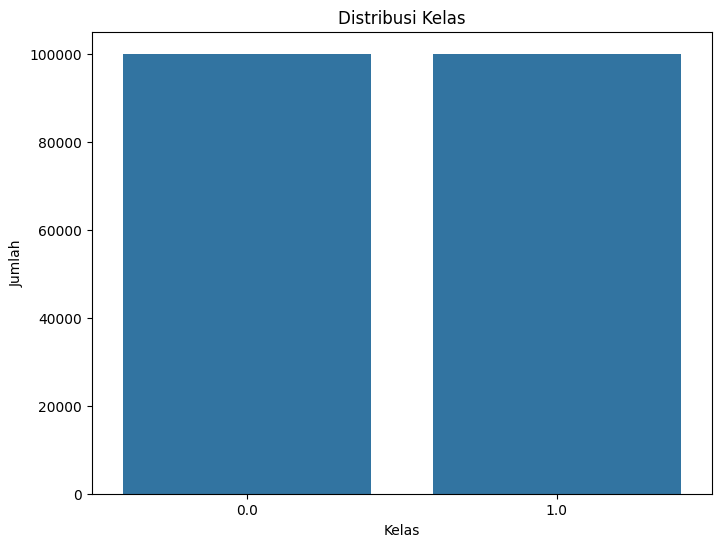

In [7]:
# Visualisasi distribusi kelas
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribusi Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.show()

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Transformer Decoder model
def create_transformer_decoder_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Reshape inputs for multi-head attention
    reshaped_inputs = tf.keras.layers.Reshape((1, input_shape[0]))(inputs)

    # Transformer Decoder Block
    decoder_input = tf.keras.layers.Input(shape=(1, input_shape[0]))
    attention_output = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=input_shape[0])(decoder_input, reshaped_inputs)
    attention_output = tf.keras.layers.LayerNormalization()(attention_output + decoder_input)

    # Feedforward network in decoder block
    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(input_shape[0])
    ])
    ffn_output = ffn(attention_output)
    decoder_output = tf.keras.layers.LayerNormalization()(ffn_output + attention_output)

    # Flatten the decoder output
    flattened = tf.keras.layers.Flatten()(decoder_output)

    # Classification head
    x = tf.keras.layers.Dense(64, activation='relu')(flattened)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Recall'])
    return model

In [10]:
import tensorflow as tf
import keras_tuner as kt
import numpy as np

# Check and clean data for NaN or infinite values
if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
    X_train = np.nan_to_num(X_train)

if np.any(np.isnan(y_train)) or np.any(np.isinf(y_train)):
    y_train = np.nan_to_num(y_train)

# Model-building function for Keras Tuner
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    # Tuning the number of hidden layers and their units
    for i in range(hp.Int('num_layers', 1, 3)):  # Number of layers between 1 and 3
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=10, max_value=10, step=10),
                                        activation='relu', kernel_initializer='he_normal'))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0),  # Gradient clipping
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

    return model

# Initialize Keras Tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='ddos_detection')

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the hyperparameter tuning
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)

Trial 5 Complete [00h 00m 22s]
val_accuracy: 0.8595625162124634

Best val_accuracy So Far: 0.8876875042915344
Total elapsed time: 00h 01m 43s


In [12]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
recalls = []
f1_scores = []
losses = []
history_list = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the best model on the current fold
    history = best_model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=1)
    history_list.append(history)

    # Evaluate the model
    scores = best_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    y_pred = best_model.predict(X_val_fold) > 0.5  # Predictions with threshold of 0.5

    # Calculate metrics
    accuracies.append(scores[1] * 100)  # Accuracy
    recalls.append(recall_score(y_val_fold, y_pred))  # Recall
    f1_scores.append(f1_score(y_val_fold, y_pred))  # F1 Score
    losses.append(scores[0])  # Loss

    print(f'Fold {fold_no} - Accuracy: {scores[1]*100:.2f}%, Recall: {recalls[-1]*100:.2f}%, F1 Score: {f1_scores[-1]*100:.2f}%, Loss: {scores[0]:.4f}')
    fold_no += 1

print(f'Mean accuracy over folds: {np.mean(accuracies):.2f}%')
print(f'Mean recall over folds: {np.mean(recalls):.2f}%')
print(f'Mean F1 Score over folds: {np.mean(f1_scores):.2f}%')
print(f'Mean loss over folds: {np.mean(losses):.4f}')

Epoch 1/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8542 - loss: 7106.3687 - recall_3: 0.8554 - val_accuracy: 0.8872 - val_loss: 7150.3047 - val_recall_3: 0.9108
Epoch 2/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8623 - loss: 3391.2708 - recall_3: 0.8575 - val_accuracy: 0.8457 - val_loss: 2554.3252 - val_recall_3: 0.9039
Epoch 3/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8641 - loss: 2542.4692 - recall_3: 0.8494 - val_accuracy: 0.8554 - val_loss: 3312.0911 - val_recall_3: 0.8106
Epoch 4/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8597 - loss: 1516.2817 - recall_3: 0.8386 - val_accuracy: 0.8721 - val_loss: 1283.6323 - val_recall_3: 0.8501
Epoch 5/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8550 - loss: 1383.0271 - recall_3: 0.8283 - val_accuracy: 0.8741 - val_loss: 1009.5893 - val_recall_3: 0.8855
Epoch 6/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8593 - loss: 1307.4745 - recall_3: 0.83

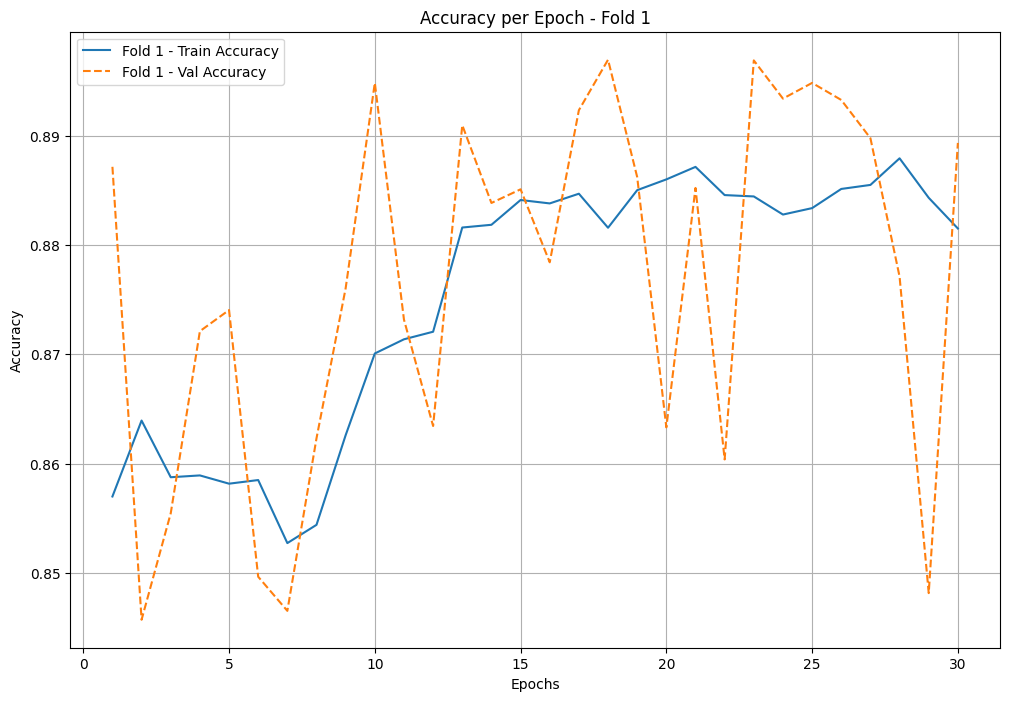

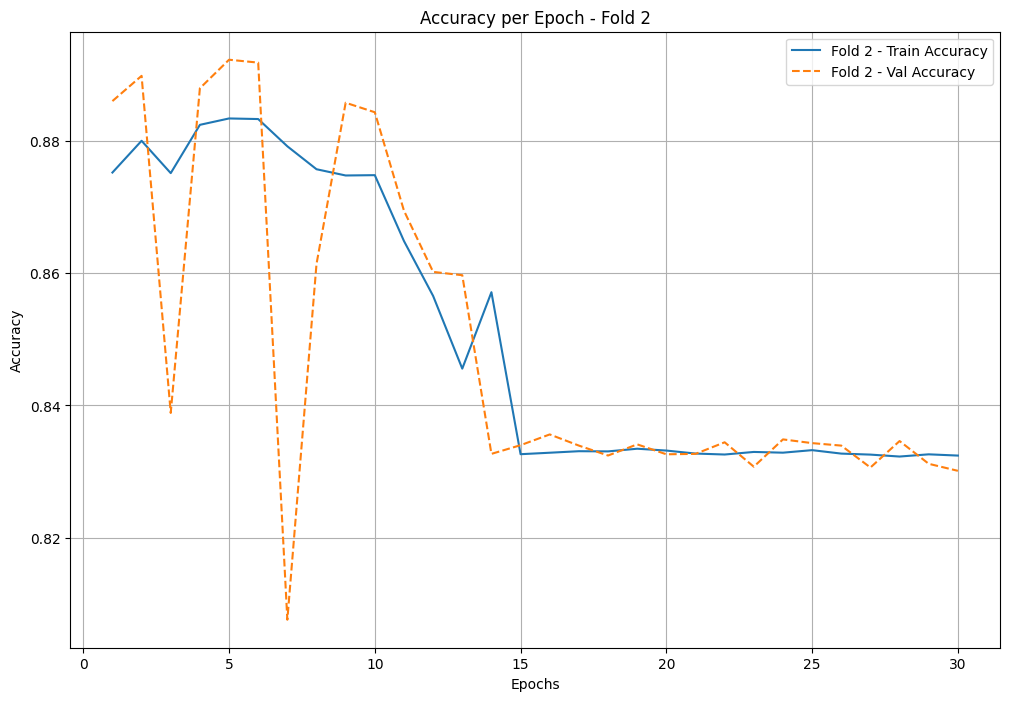

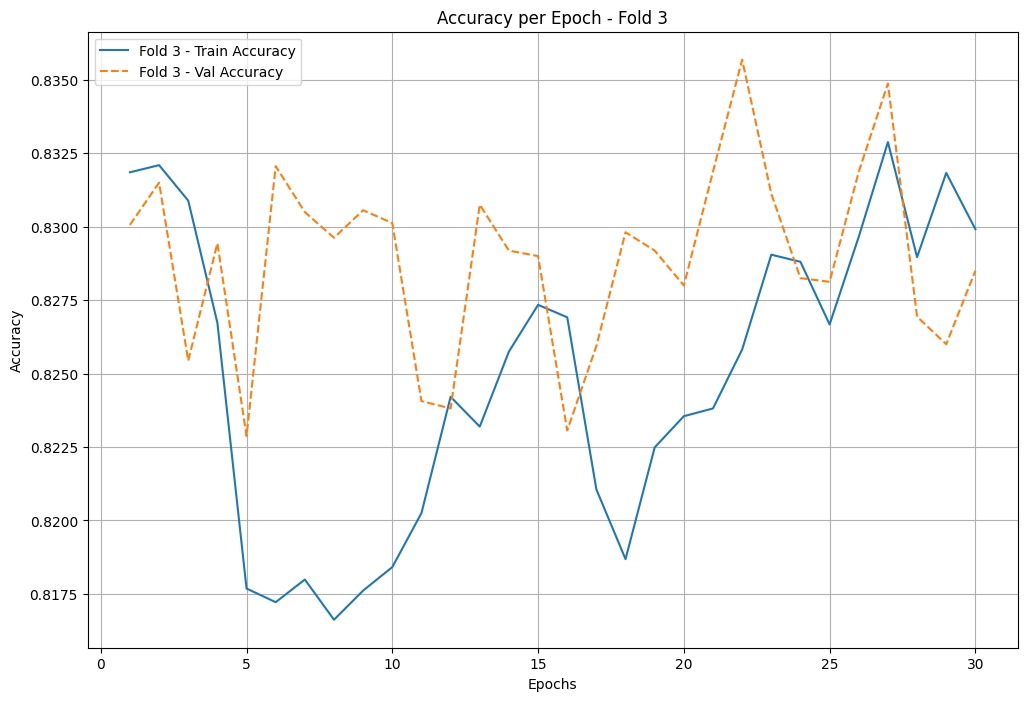

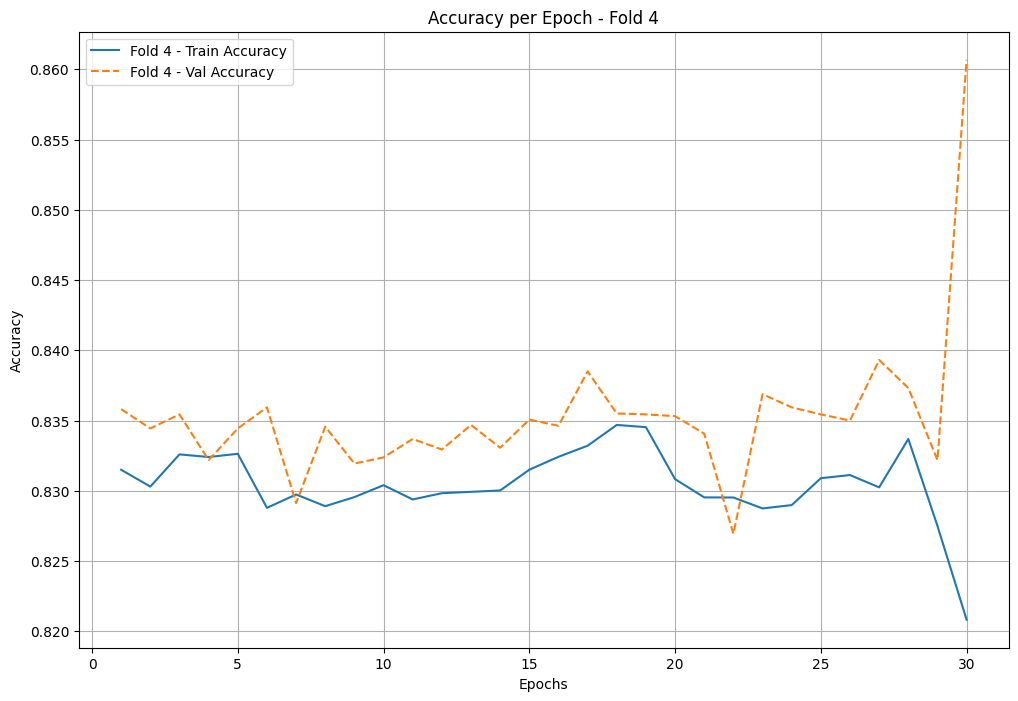

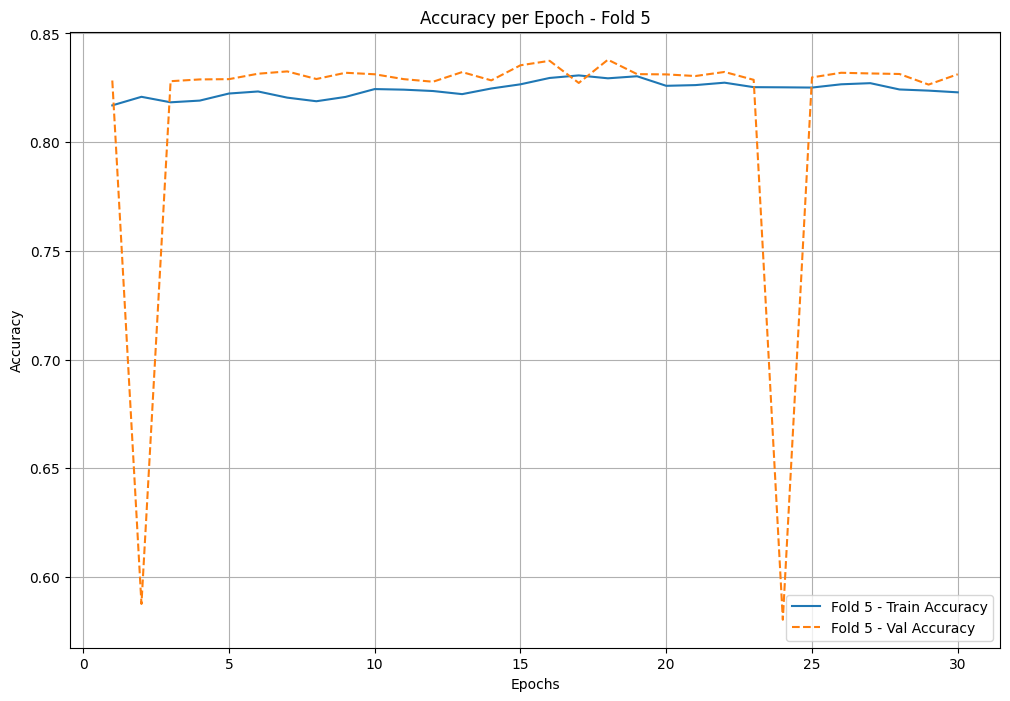

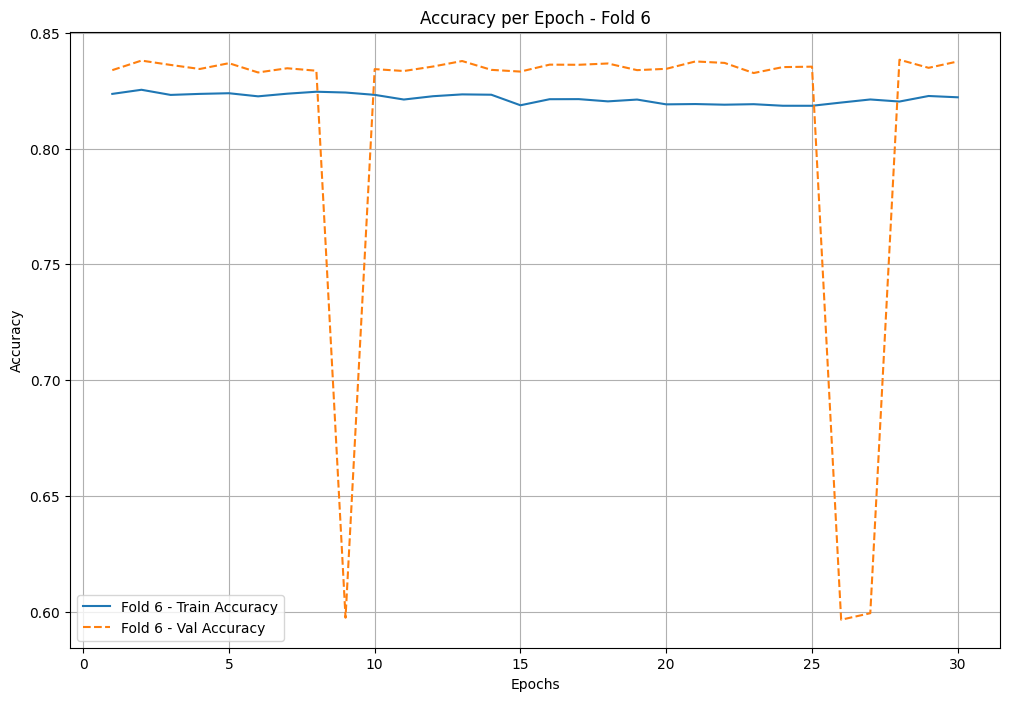

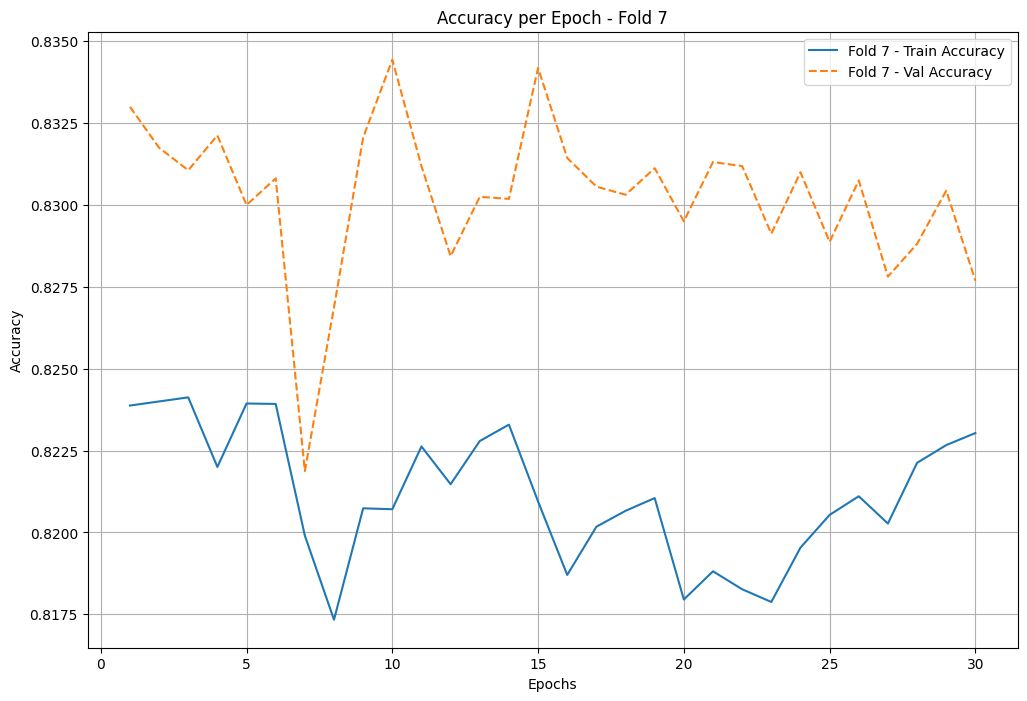

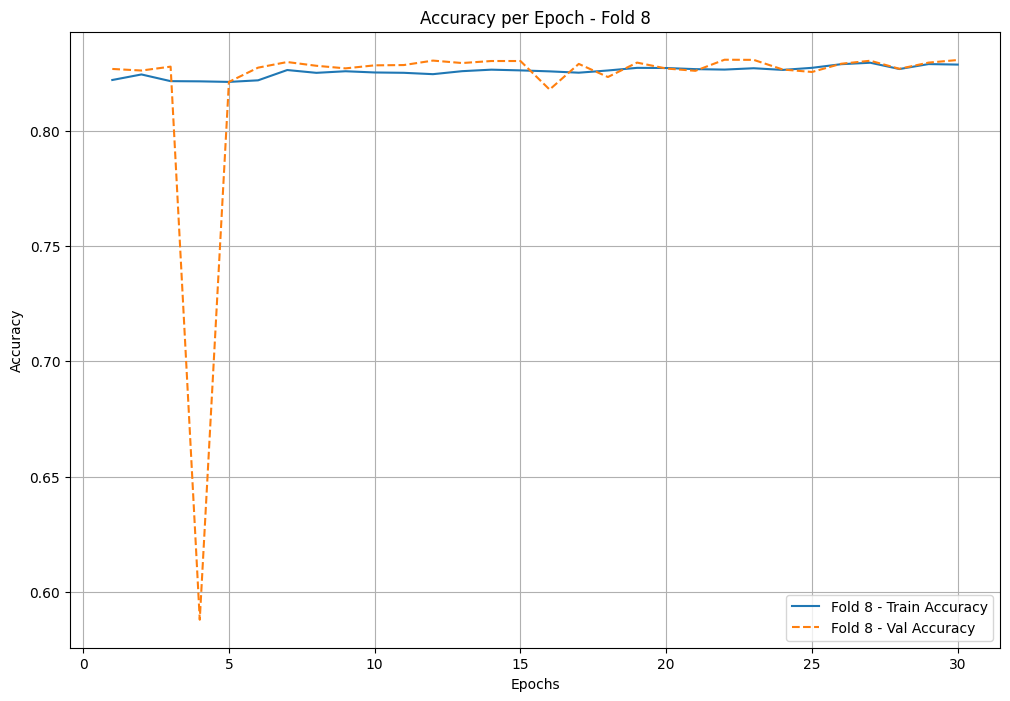

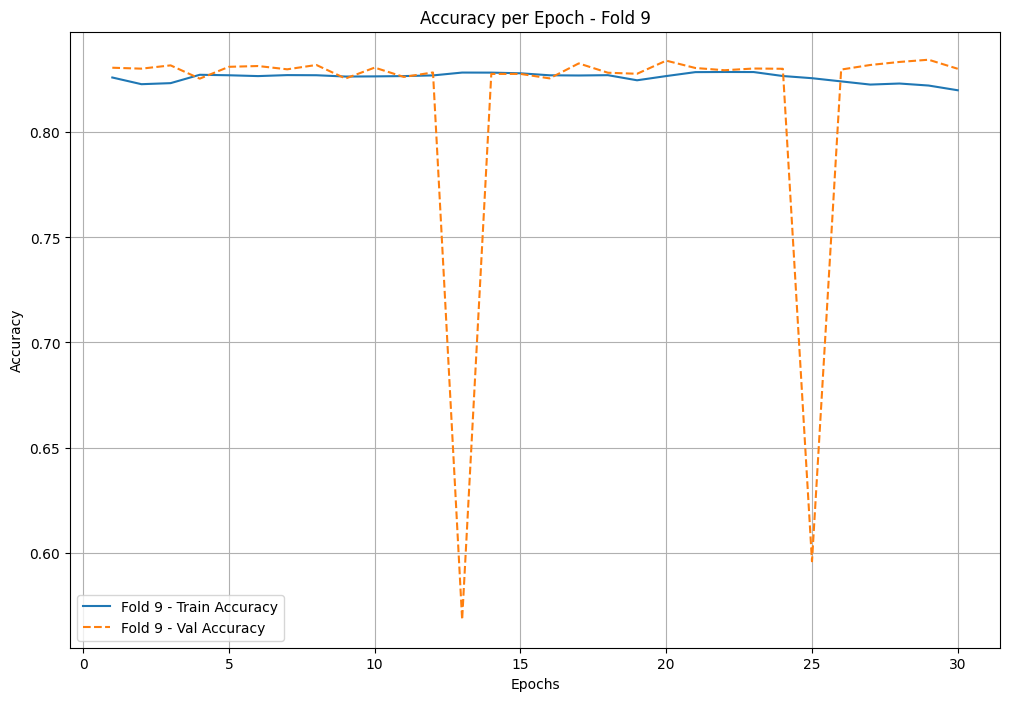

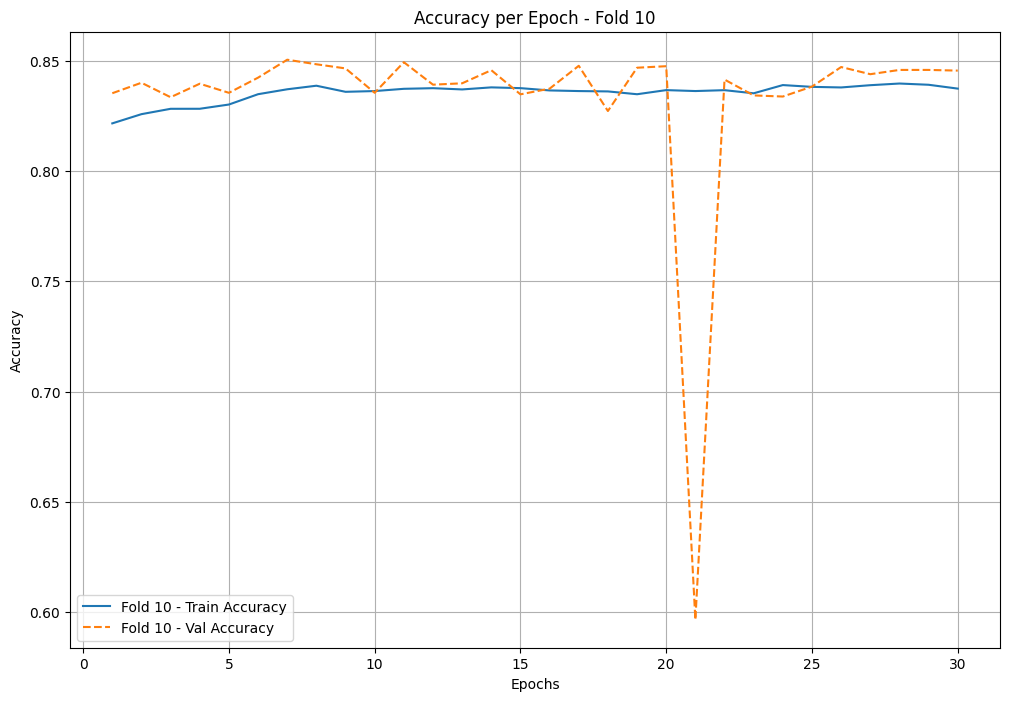

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


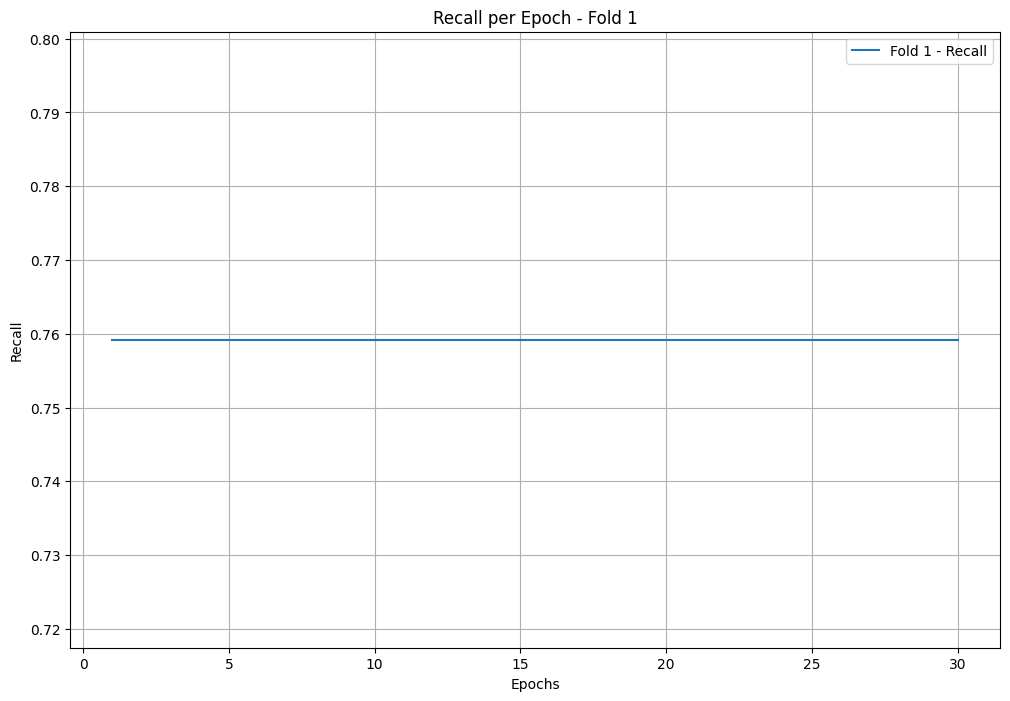

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


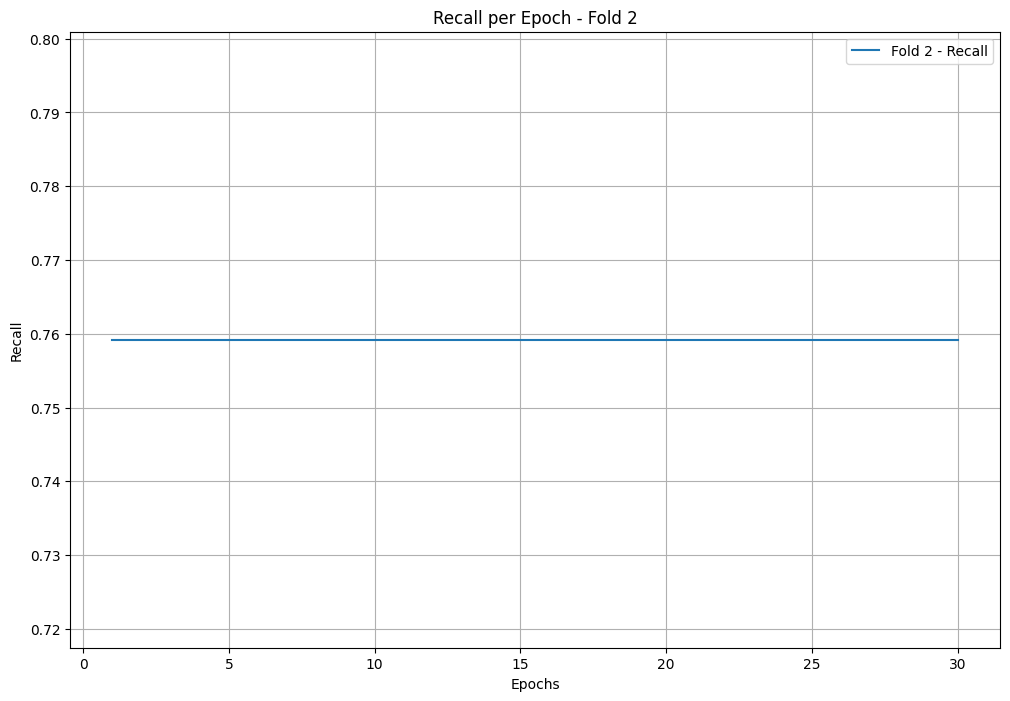

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


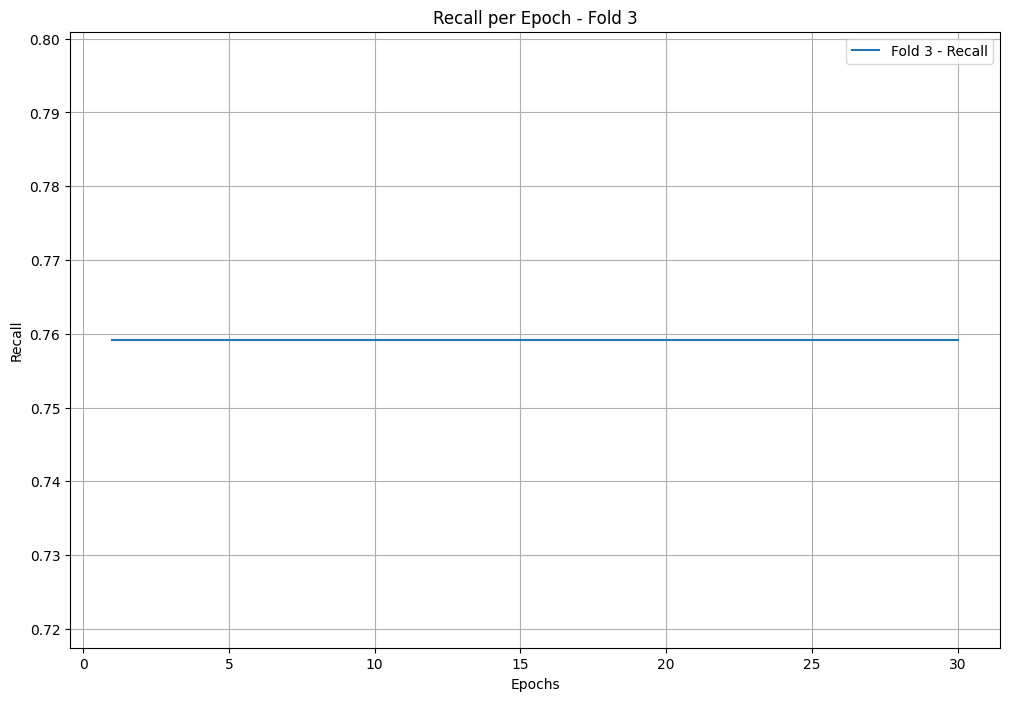

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


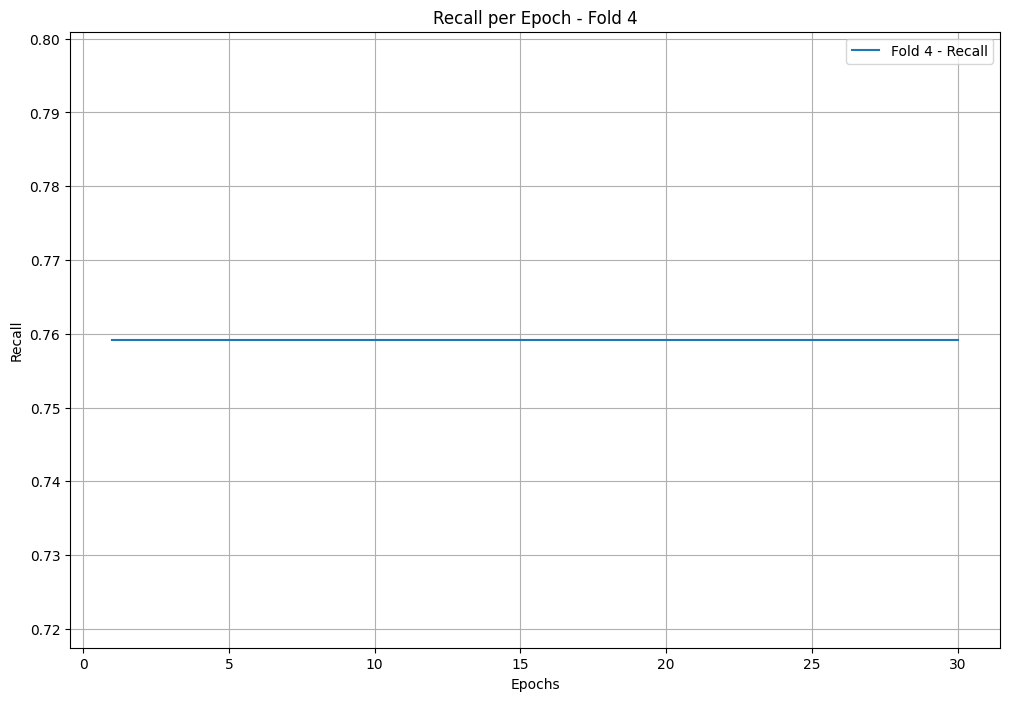

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


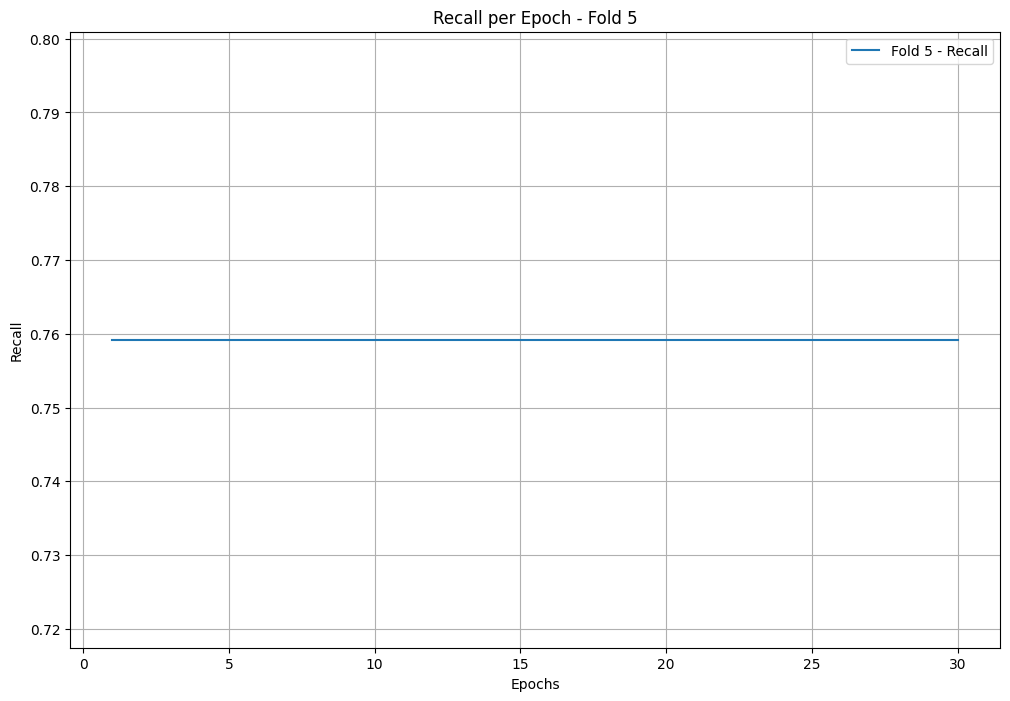

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


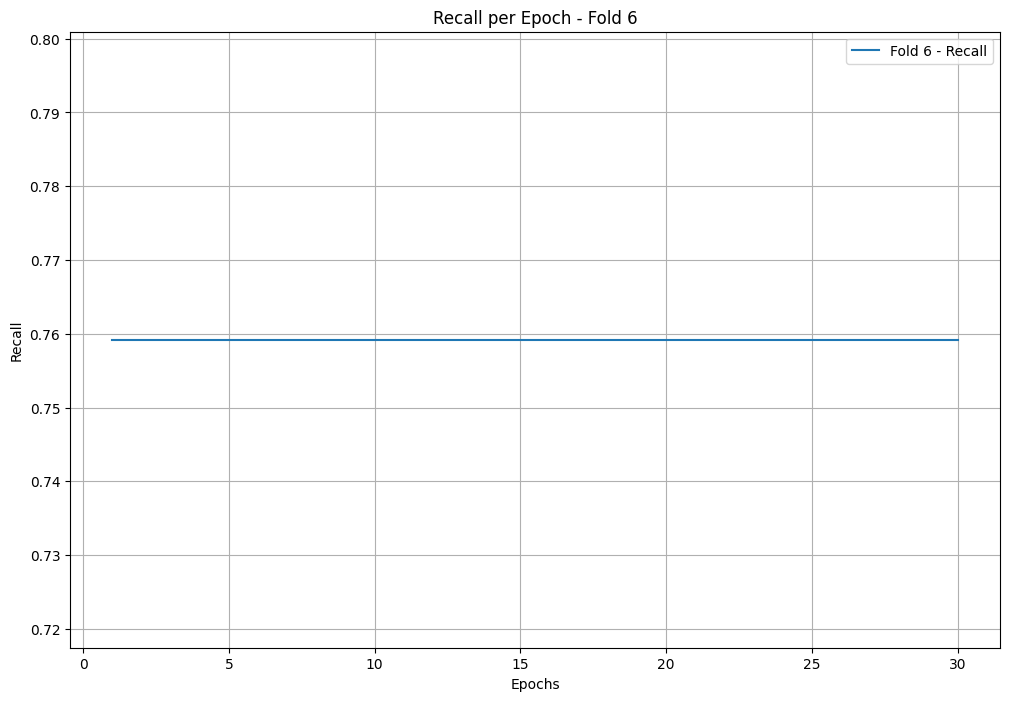

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


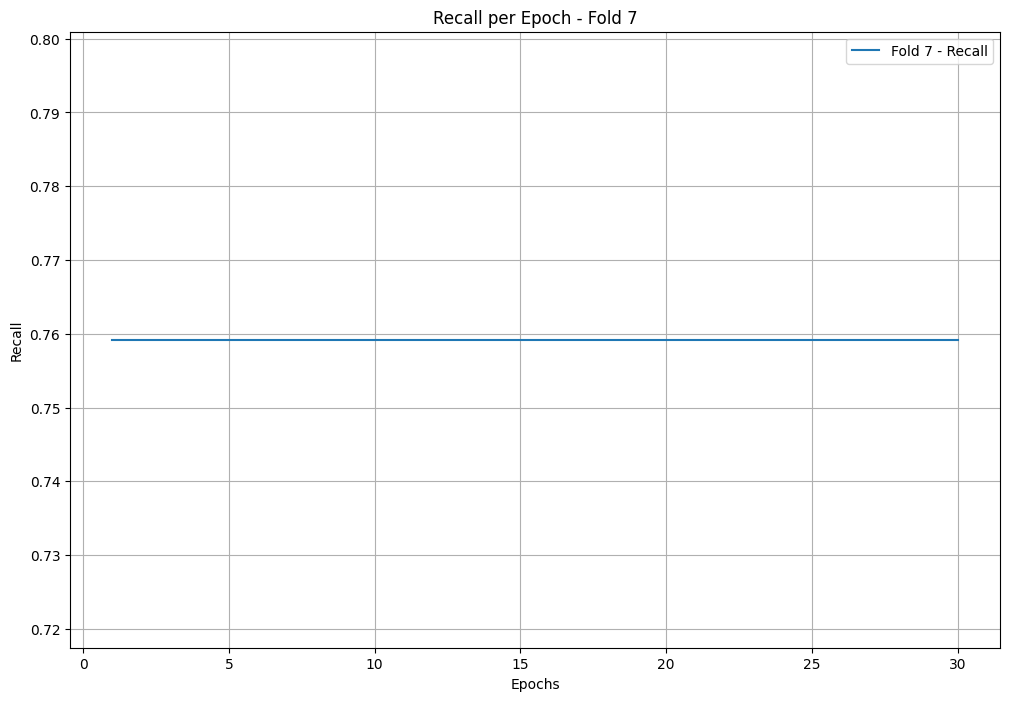

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


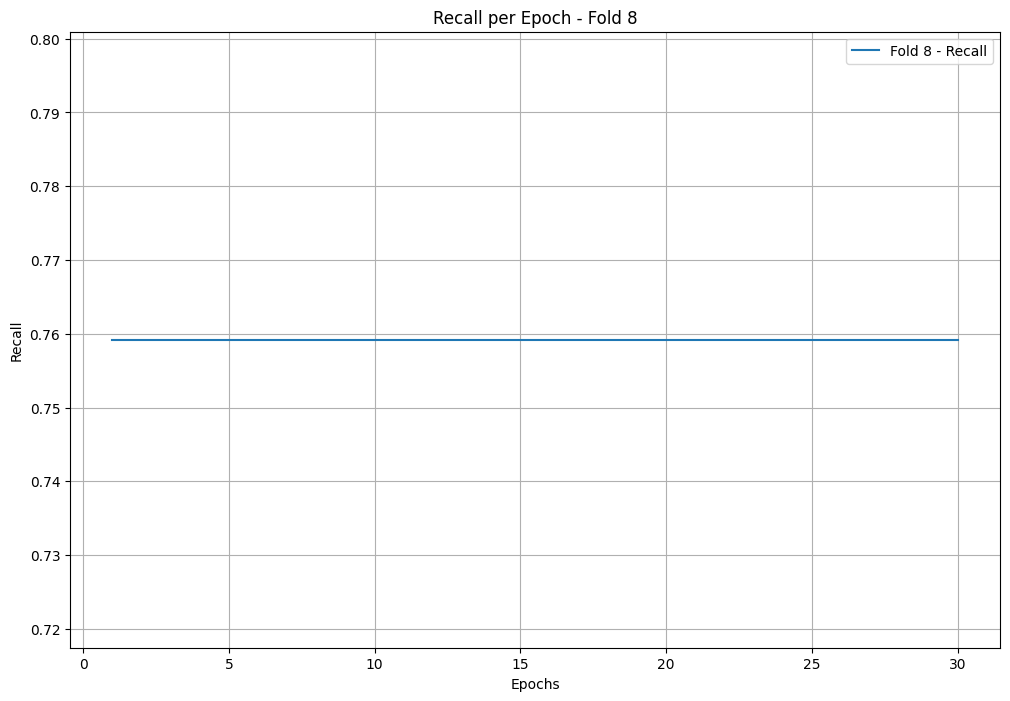

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


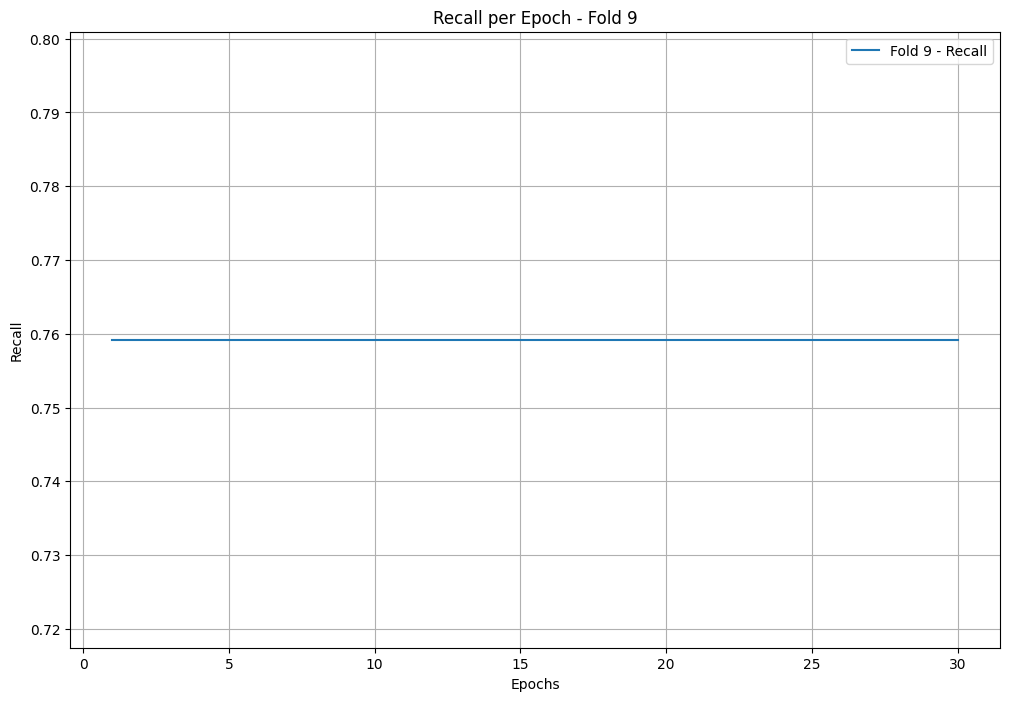

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


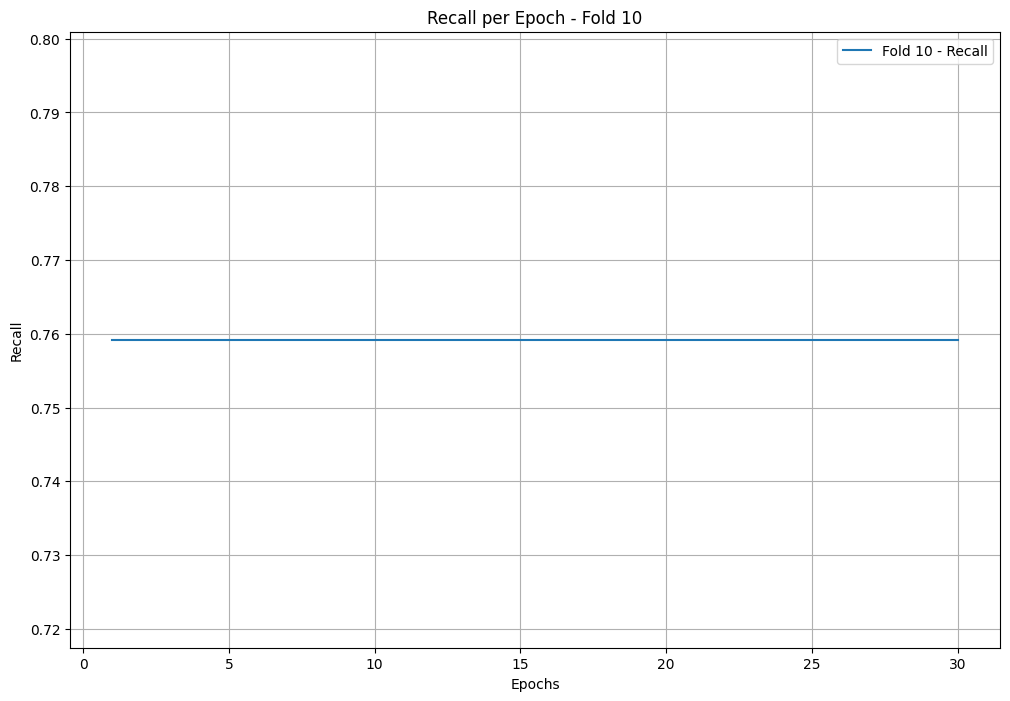

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


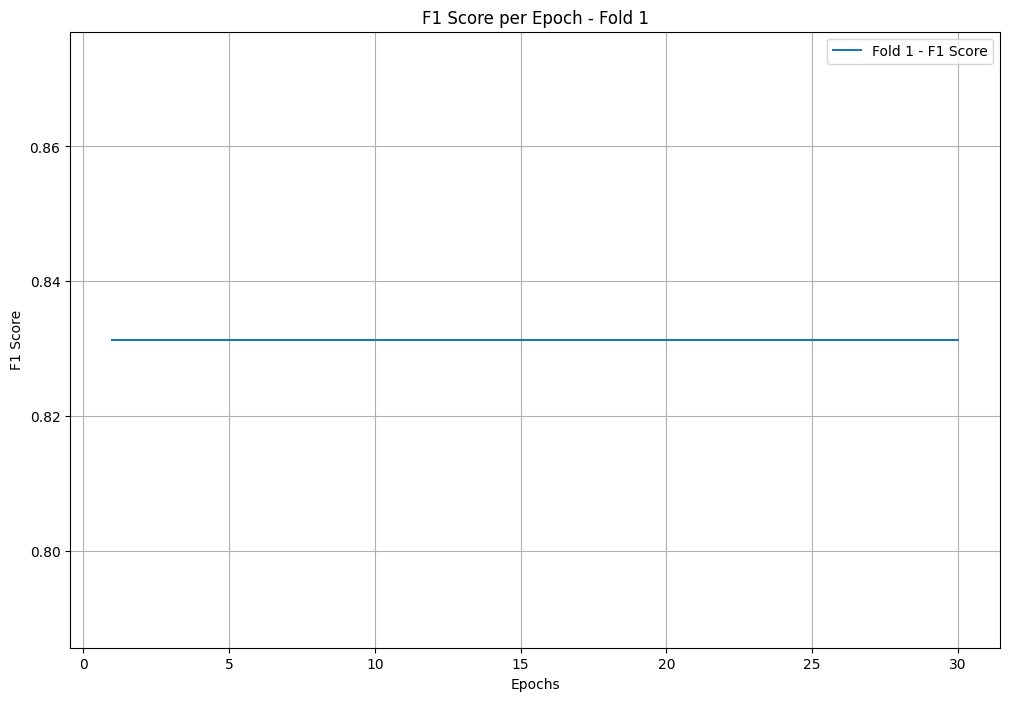

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


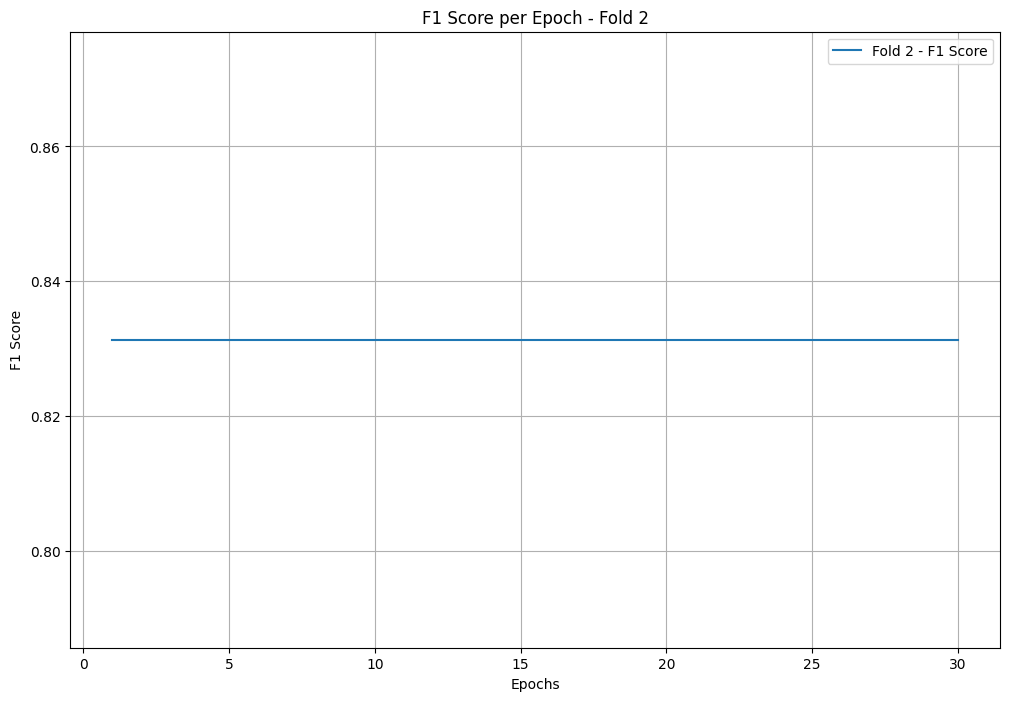

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


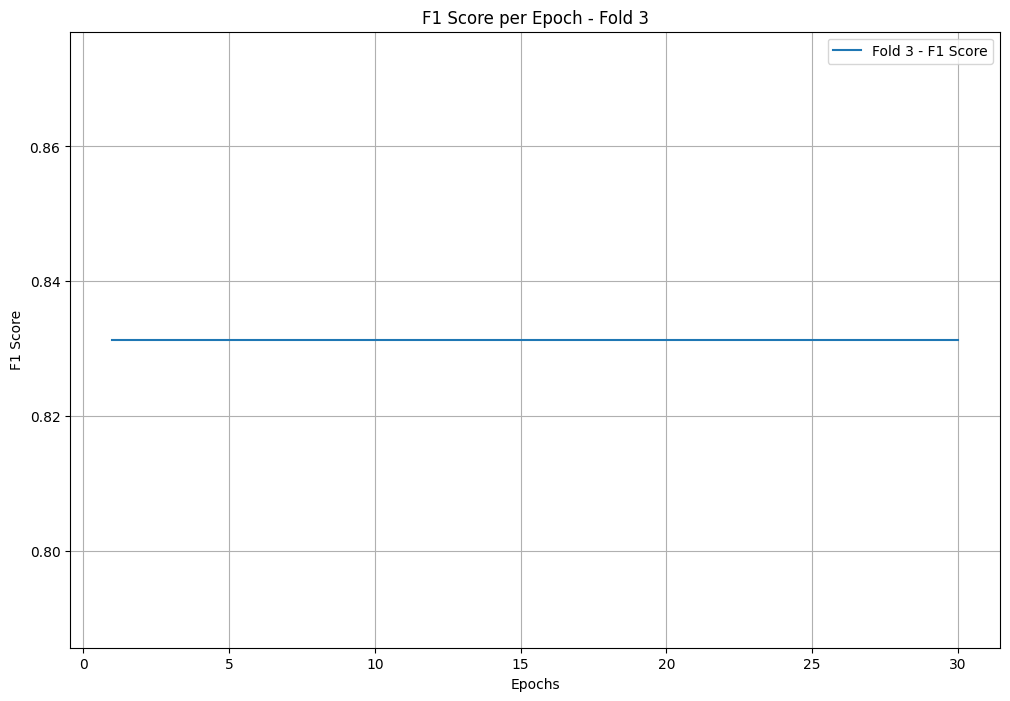

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


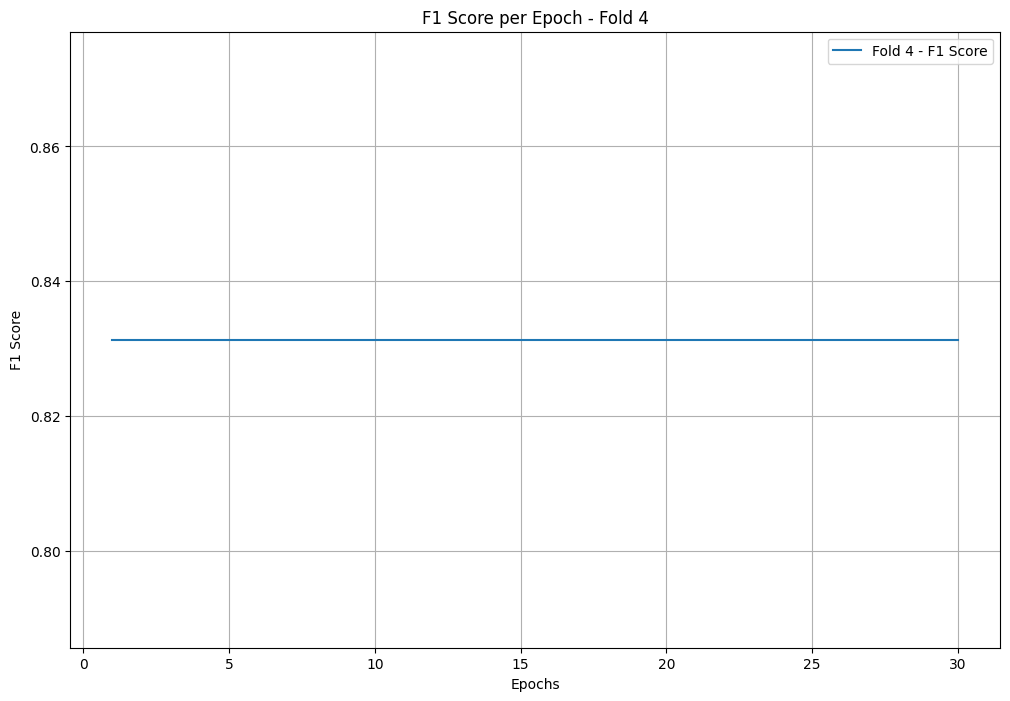

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


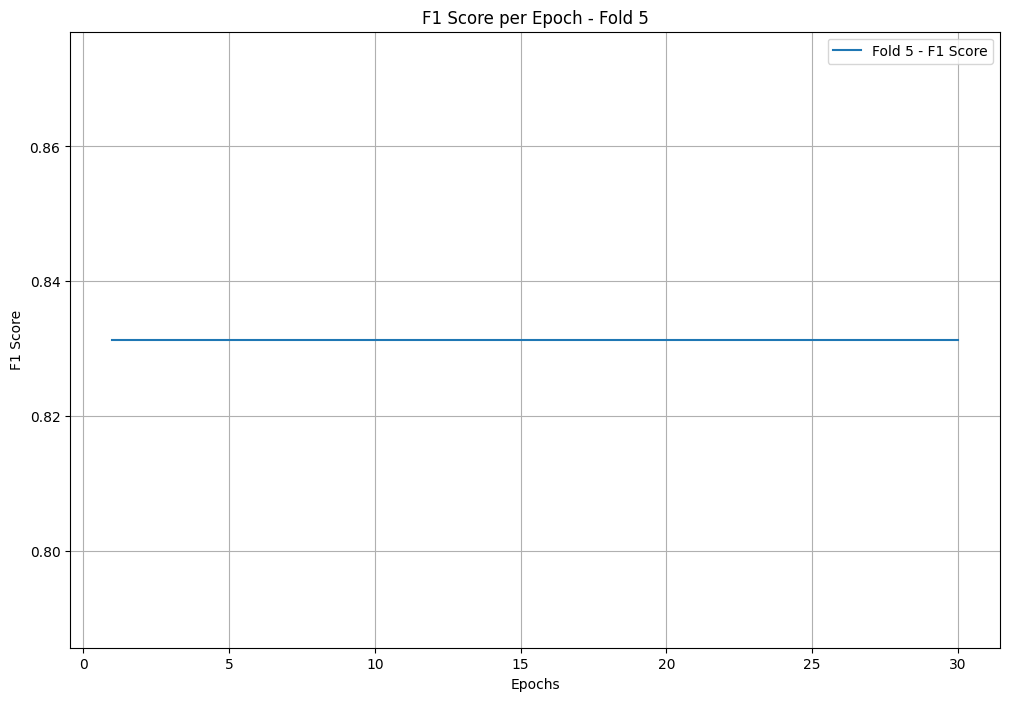

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


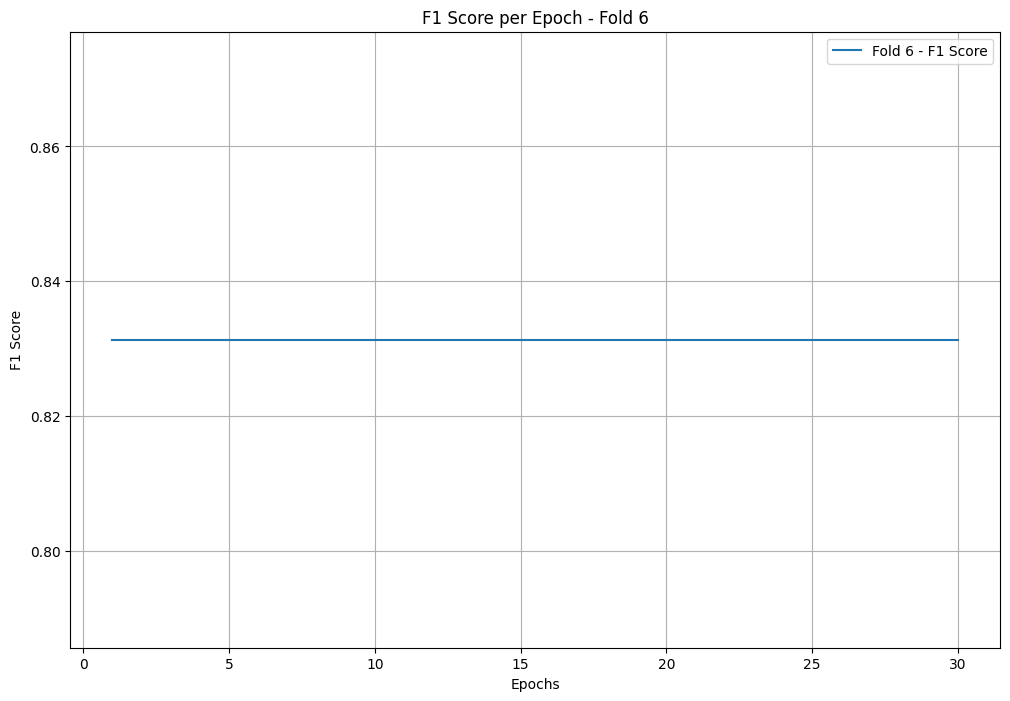

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


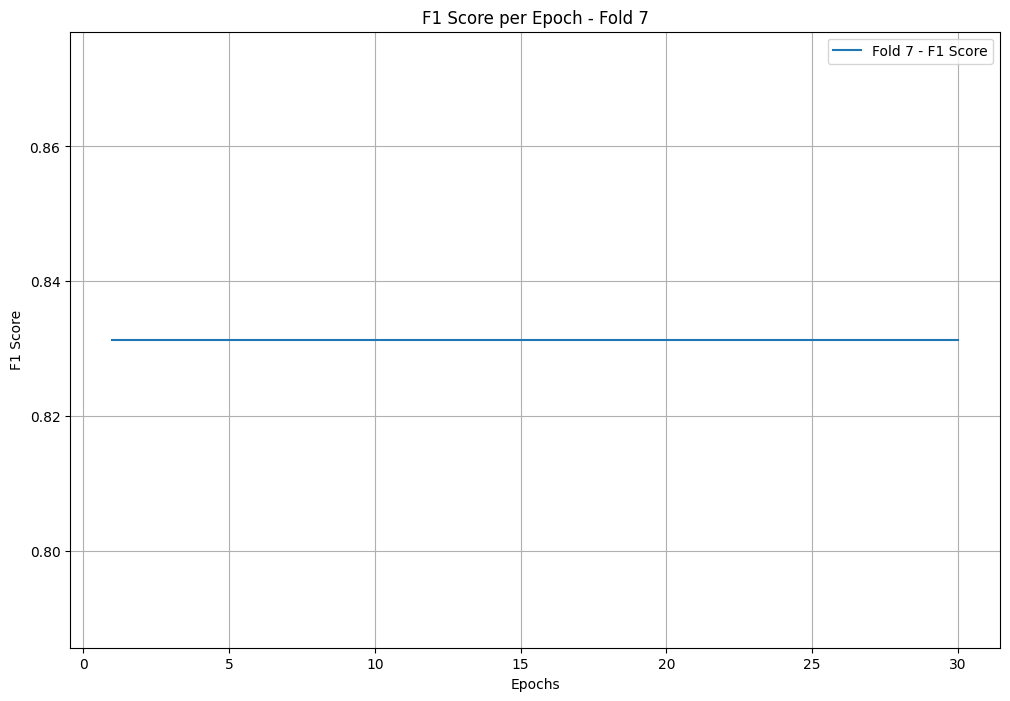

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


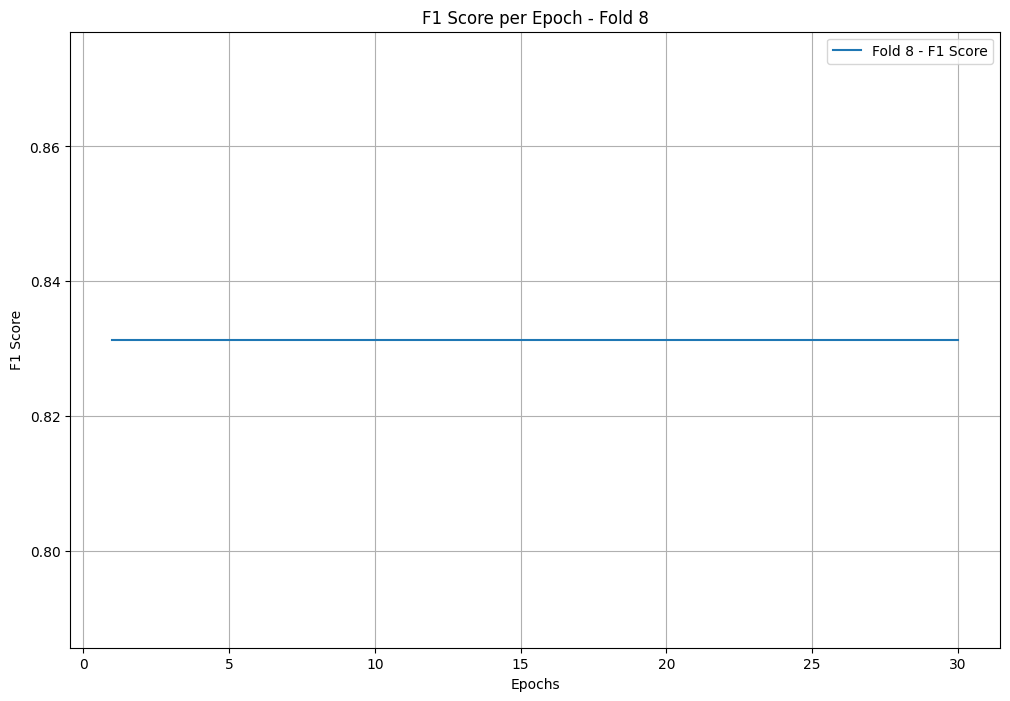

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


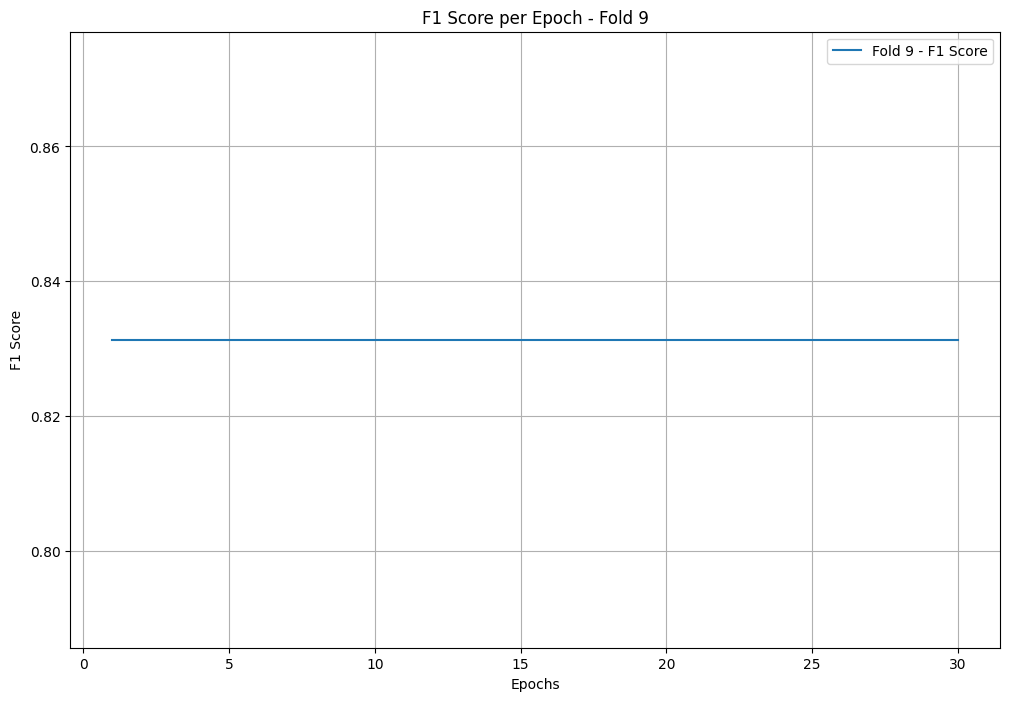

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


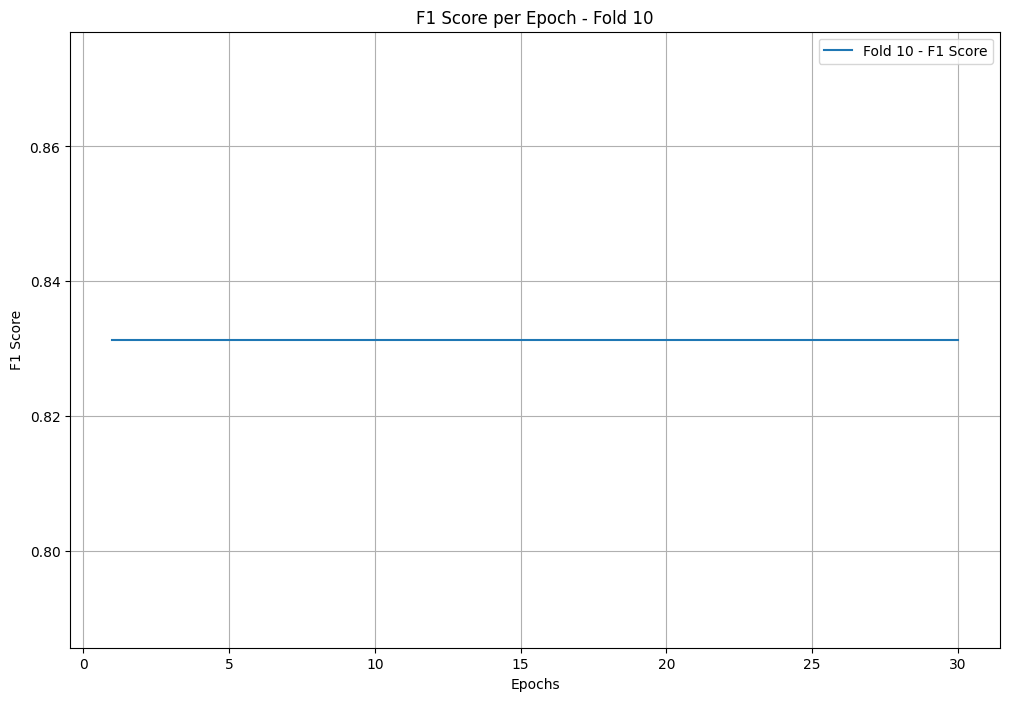

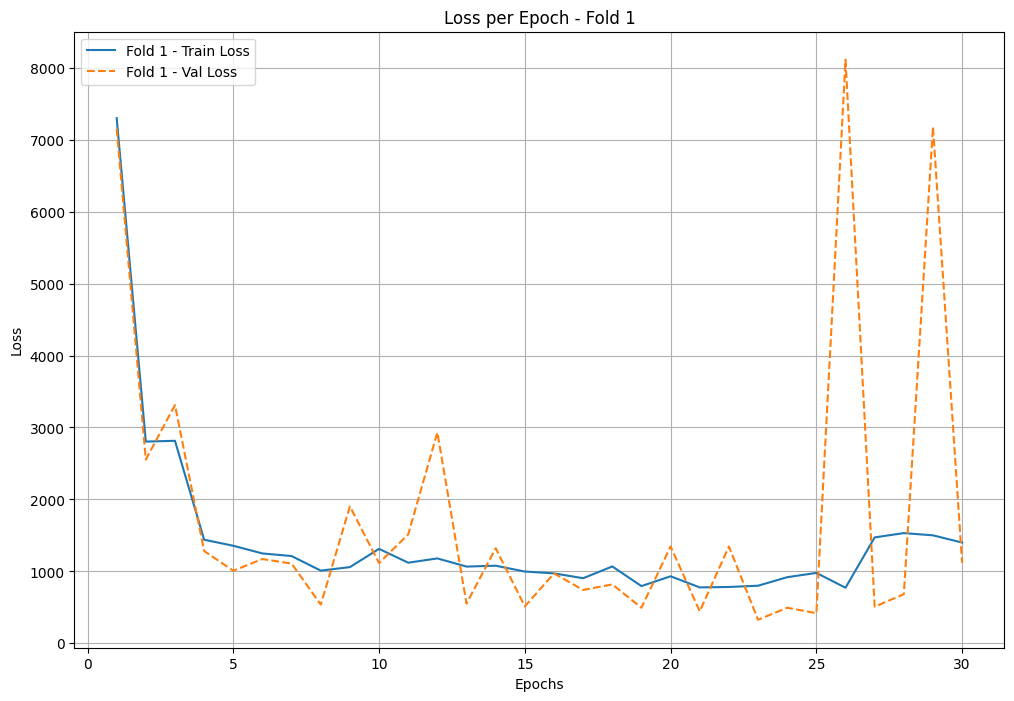

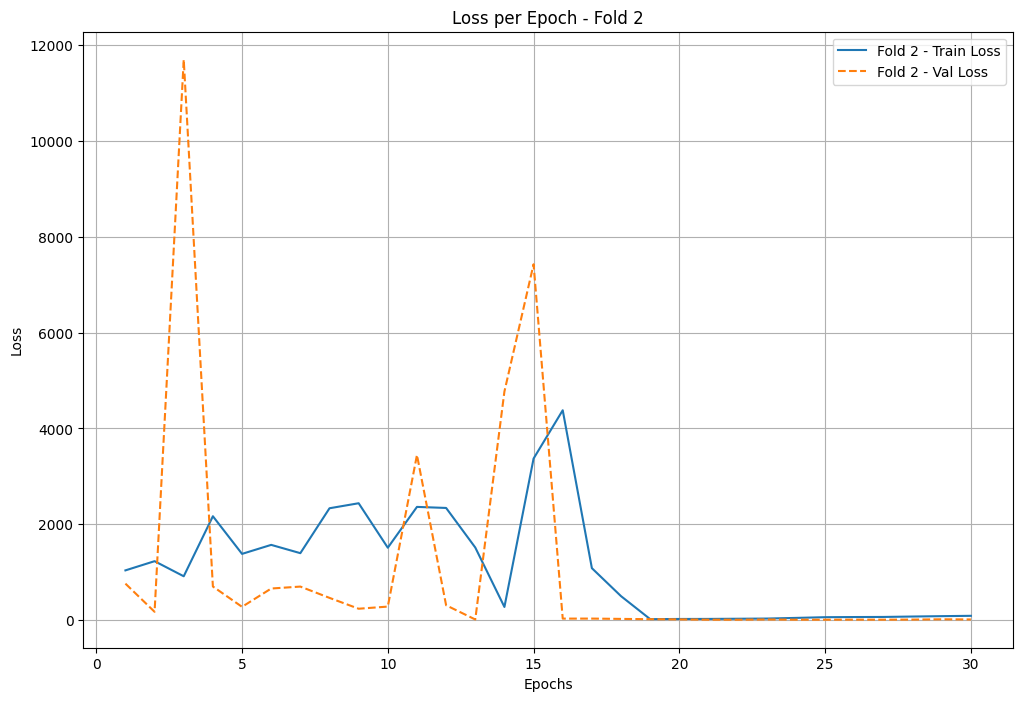

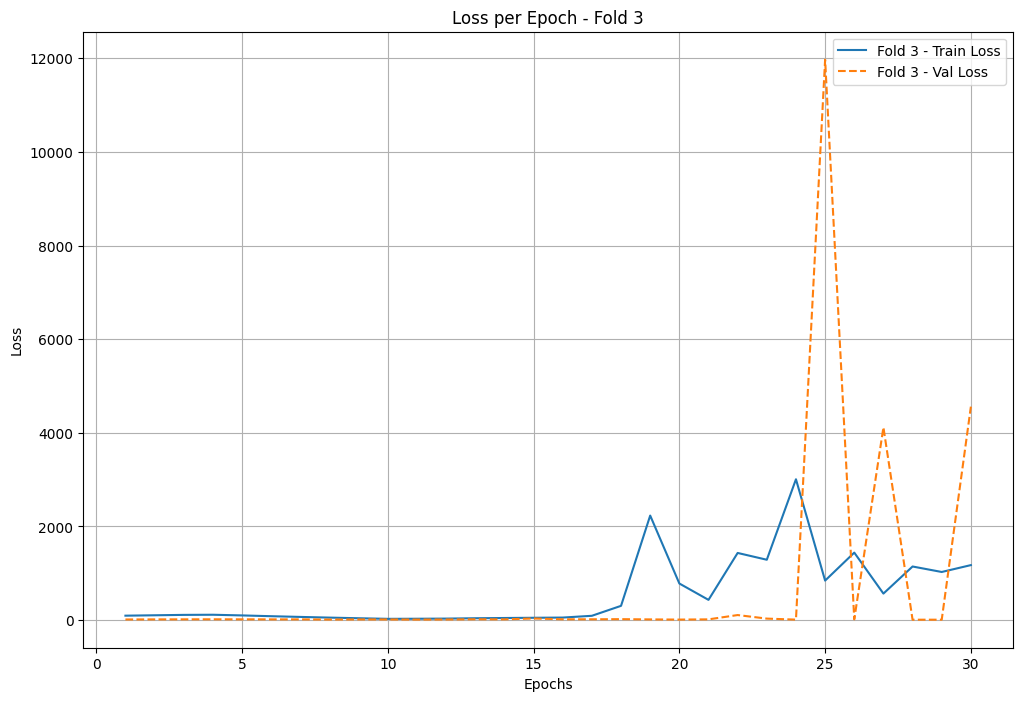

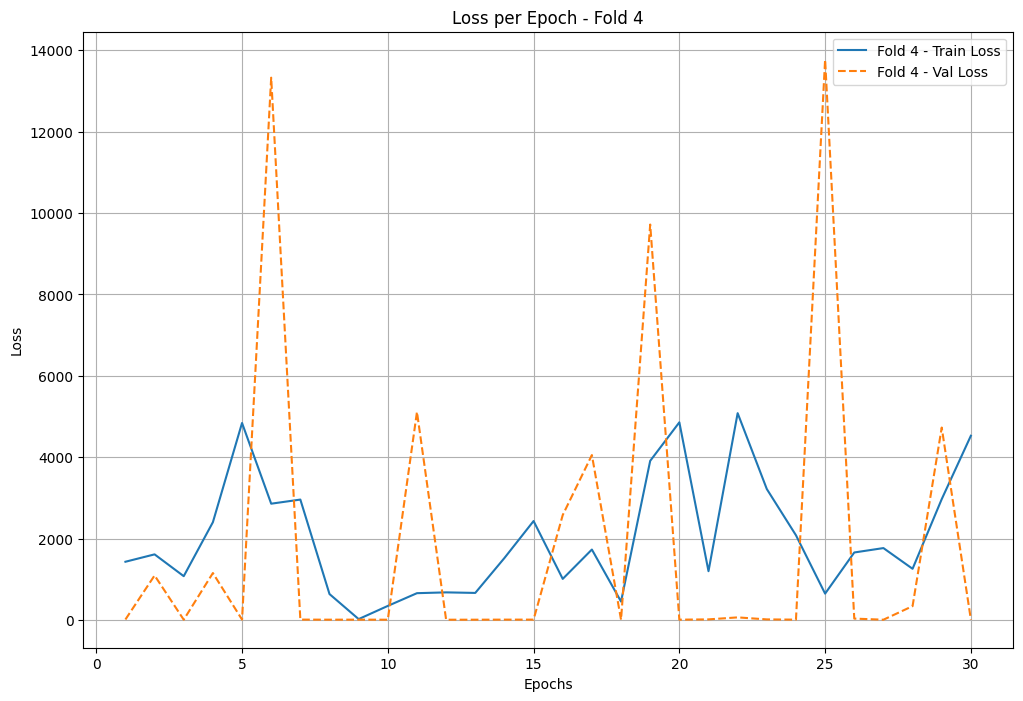

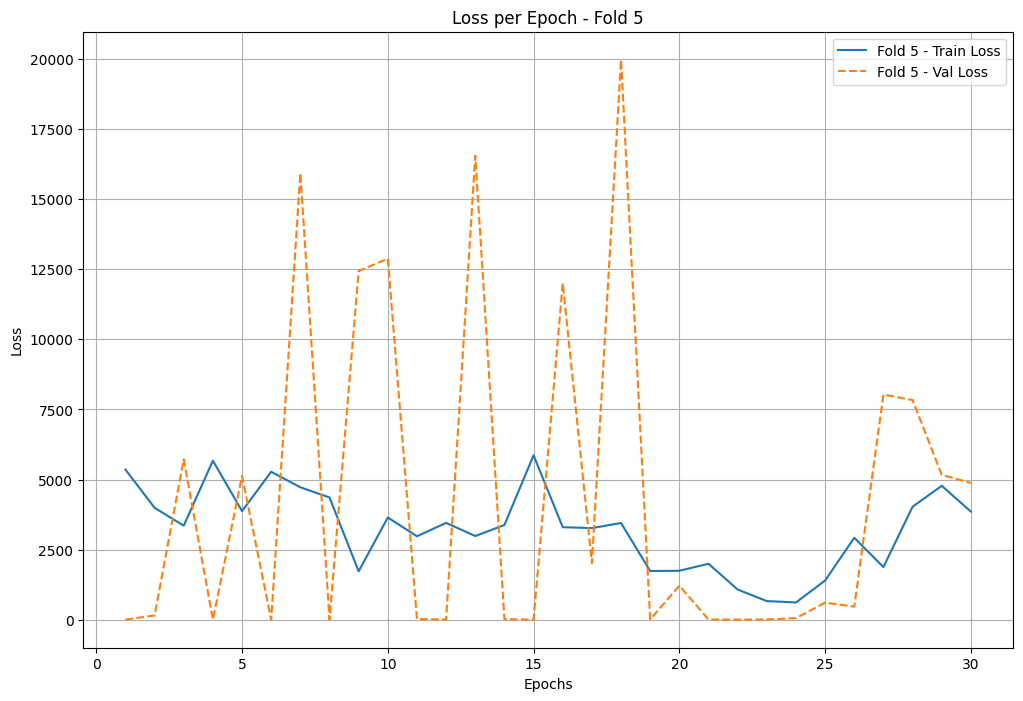

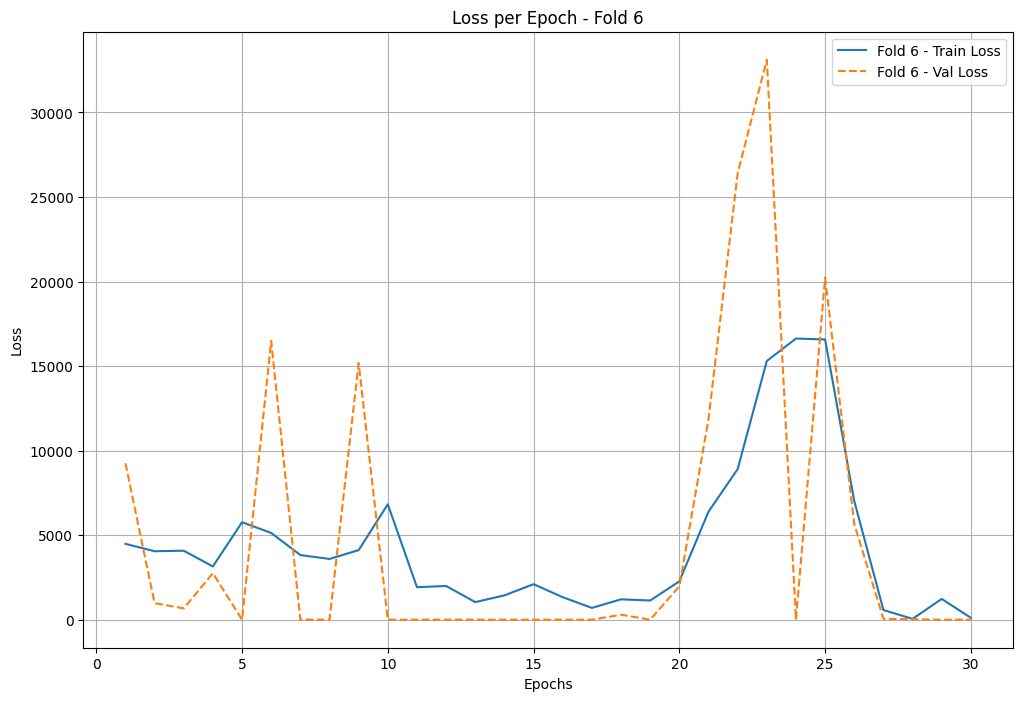

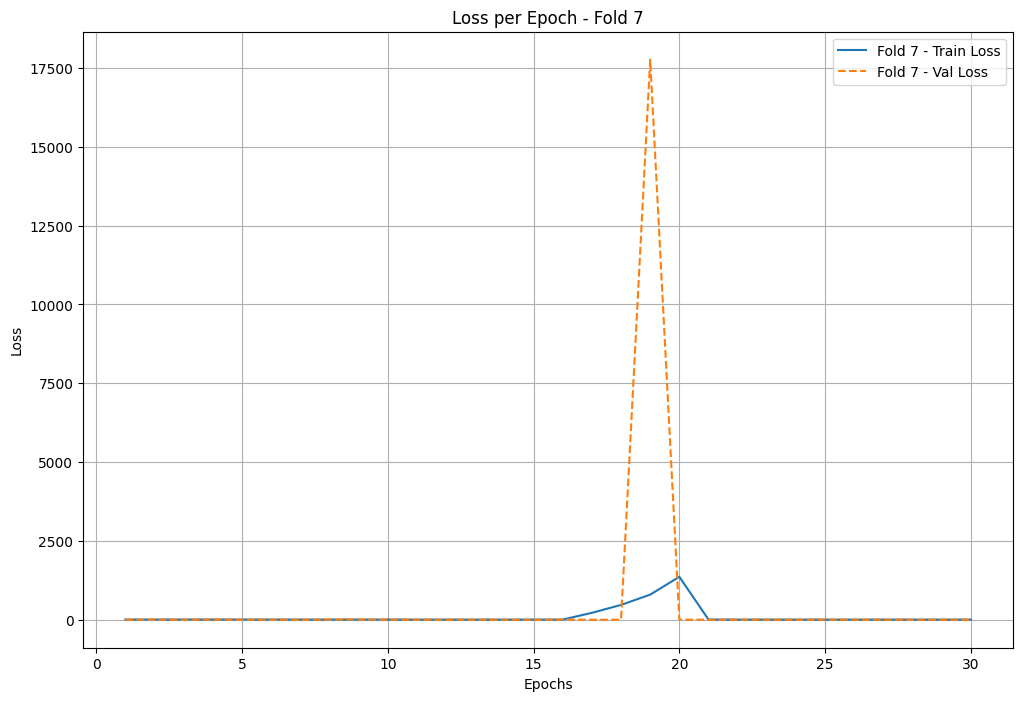

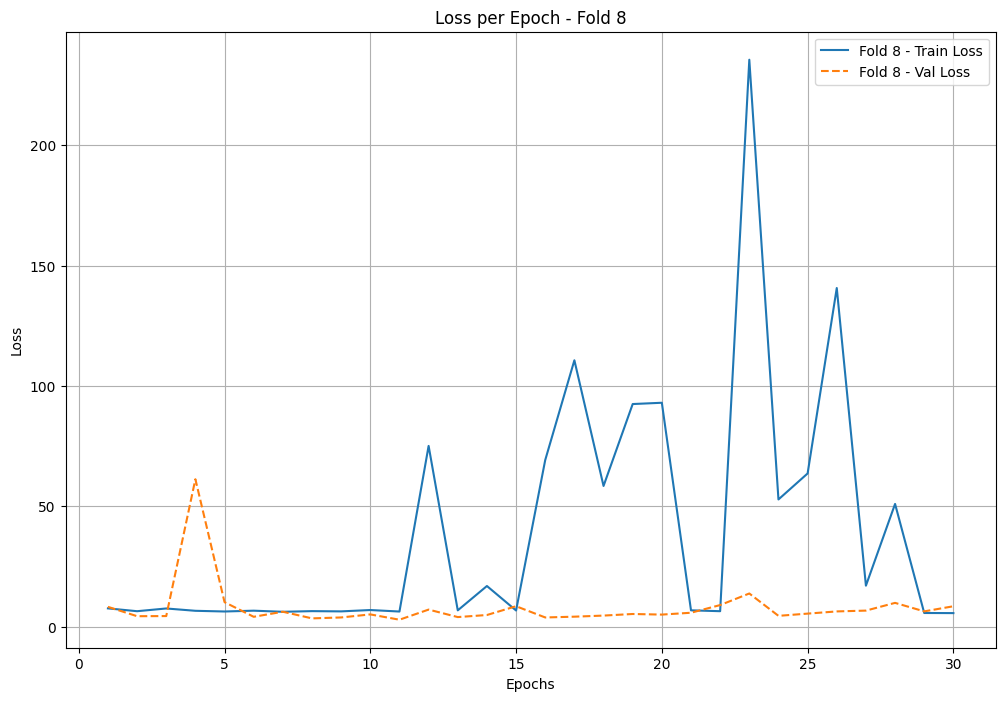

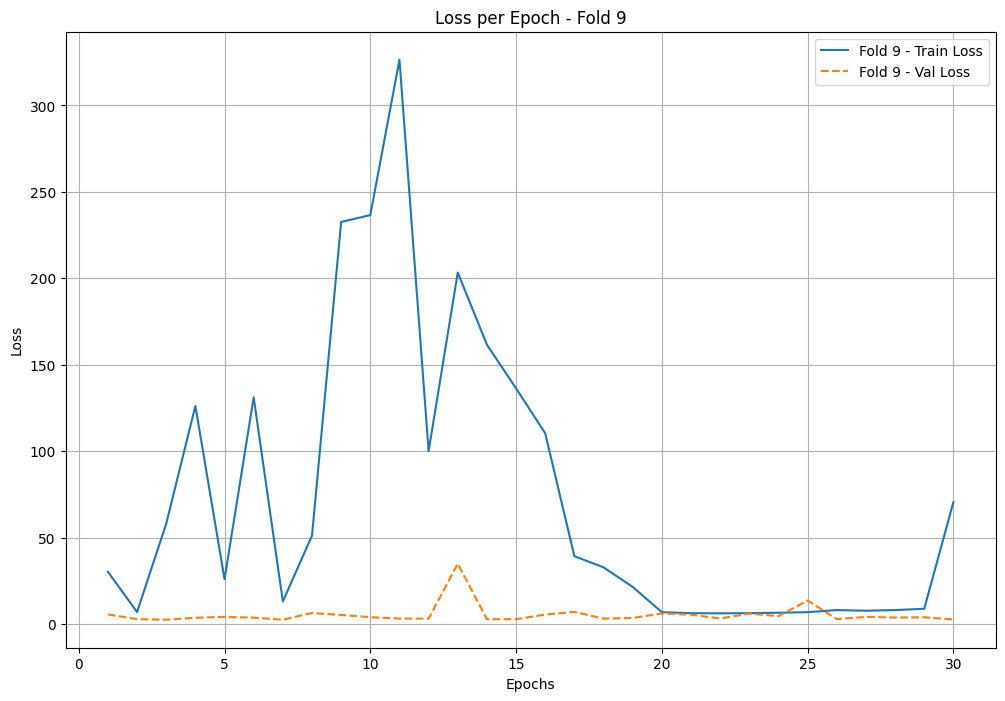

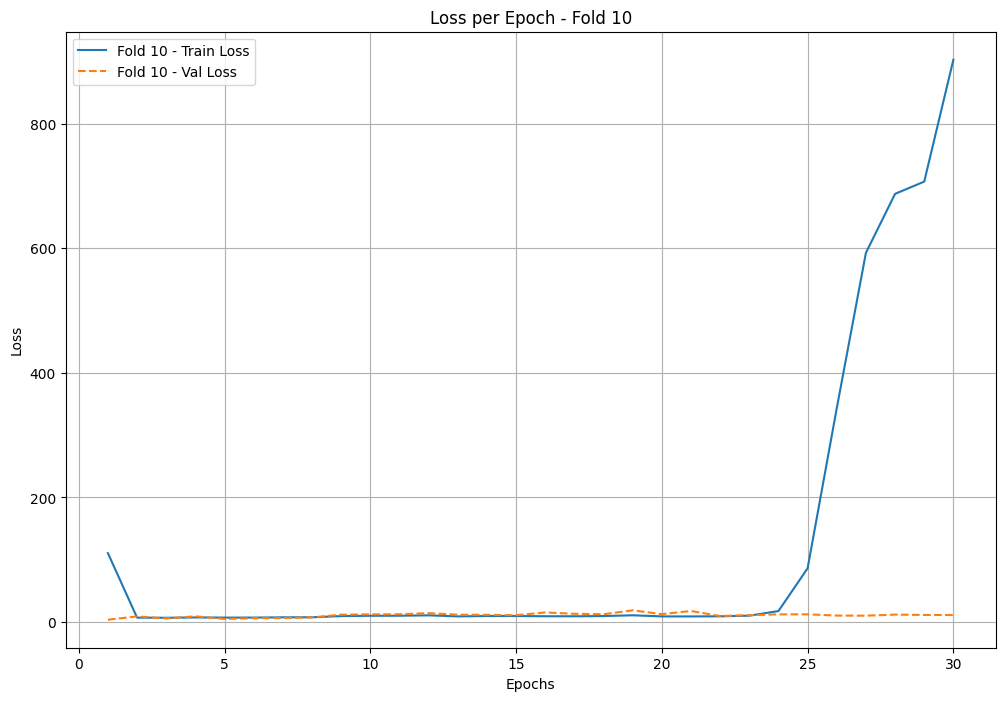

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, 31)  # Karena epoch yang digunakan adalah 30

# Visualisasi per fold untuk akurasi
for fold_no, history in enumerate(history_list, start=1):
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history.history['accuracy'], label=f'Fold {fold_no} - Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label=f'Fold {fold_no} - Val Accuracy', linestyle='--')

    plt.title(f'Accuracy per Epoch - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualisasi per fold untuk recall
for fold_no, history in enumerate(history_list, start=1):
    val_recall = recall_score(y_val_fold, (best_model.predict(X_val_fold) > 0.5))
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, [val_recall] * len(epochs), label=f'Fold {fold_no} - Recall')

    plt.title(f'Recall per Epoch - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualisasi per fold untuk f1 score
for fold_no, history in enumerate(history_list, start=1):
    val_f1 = f1_score(y_val_fold, (best_model.predict(X_val_fold) > 0.5))
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, [val_f1] * len(epochs), label=f'Fold {fold_no} - F1 Score')

    plt.title(f'F1 Score per Epoch - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualisasi per fold untuk loss
for fold_no, history in enumerate(history_list, start=1):
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history.history['loss'], label=f'Fold {fold_no} - Train Loss')
    plt.plot(epochs, history.history['val_loss'], label=f'Fold {fold_no} - Val Loss', linestyle='--')

    plt.title(f'Loss per Epoch - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

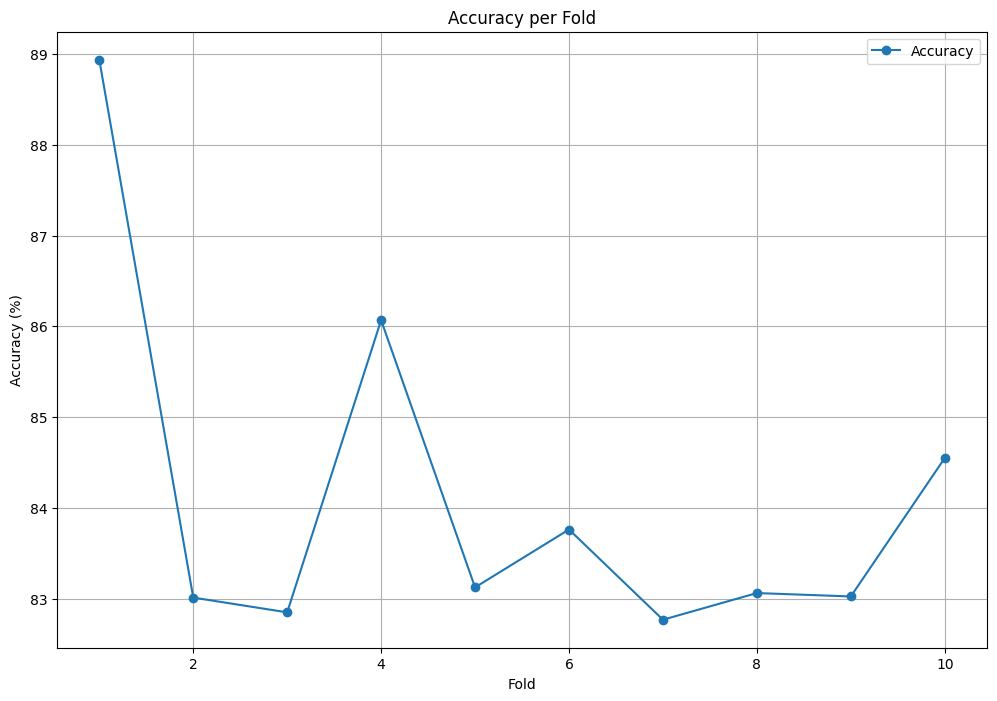

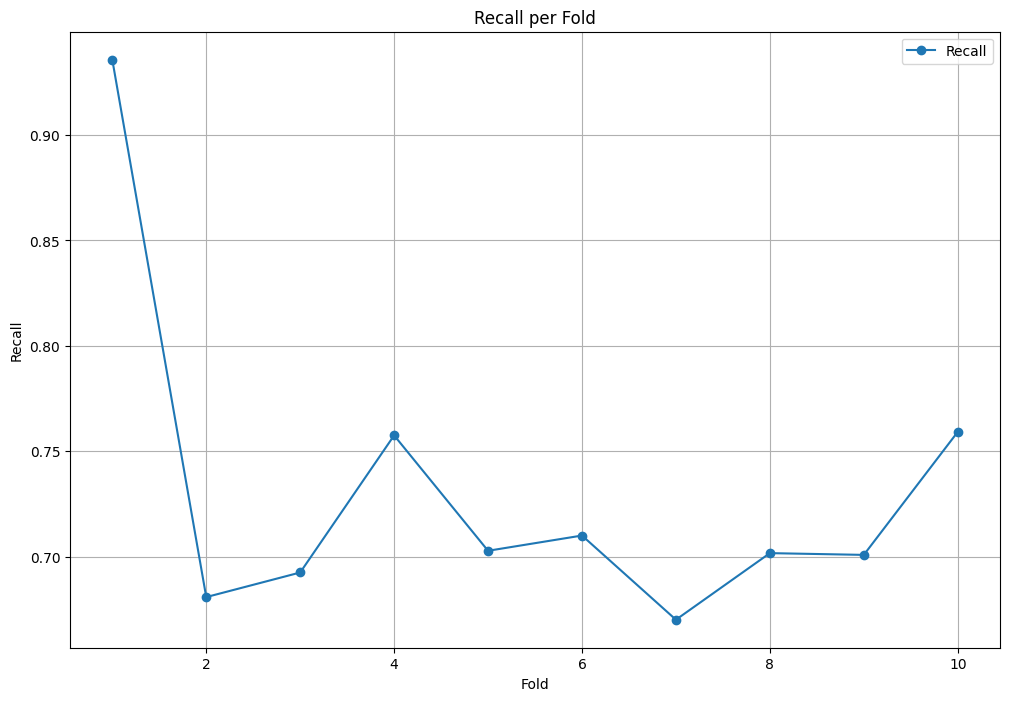

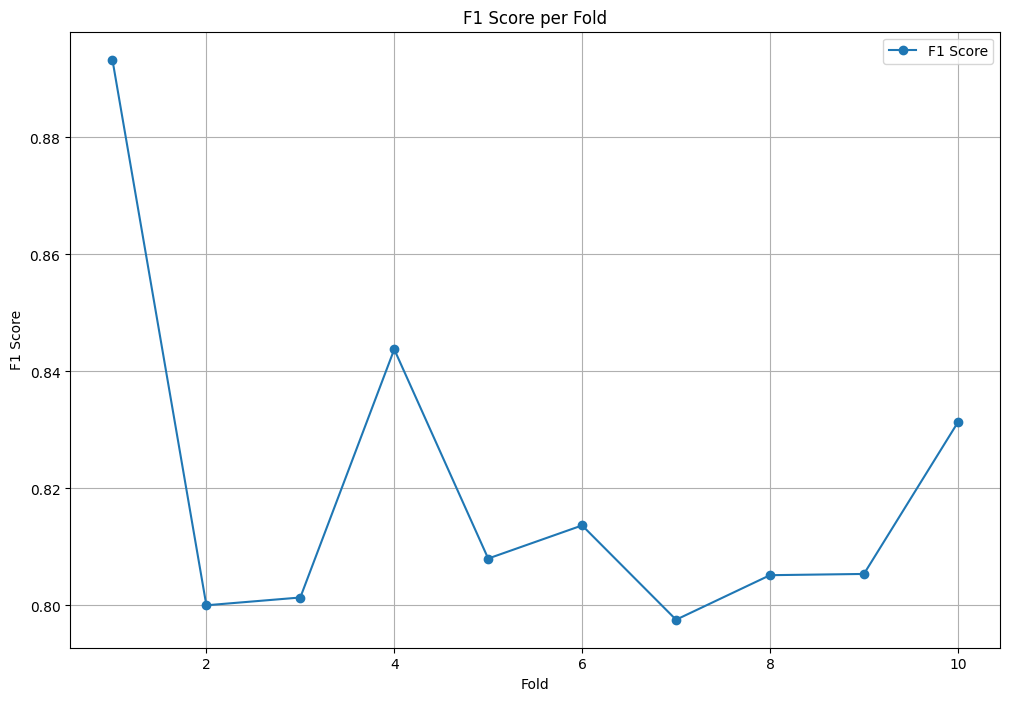

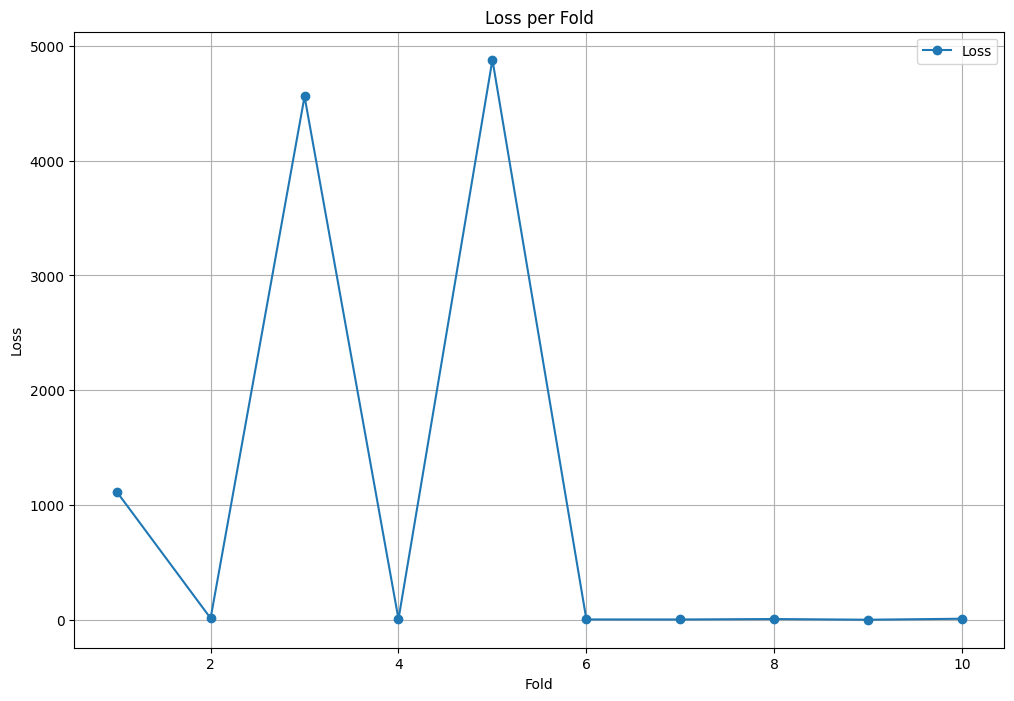

In [15]:
import matplotlib.pyplot as plt

# Visualisasi metrik per fold
folds = range(1, 11)  # Untuk 10 fold

# Akurasi per fold
plt.figure(figsize=(12, 8))
plt.plot(folds, accuracies, marker='o', label='Accuracy')
plt.title('Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

# Recall per fold
plt.figure(figsize=(12, 8))
plt.plot(folds, recalls, marker='o', label='Recall')
plt.title('Recall per Fold')
plt.xlabel('Fold')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()

# F1 Score per fold
plt.figure(figsize=(12, 8))
plt.plot(folds, f1_scores, marker='o', label='F1 Score')
plt.title('F1 Score per Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.show()

# Loss per fold
plt.figure(figsize=(12, 8))
plt.plot(folds, losses, marker='o', label='Loss')
plt.title('Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


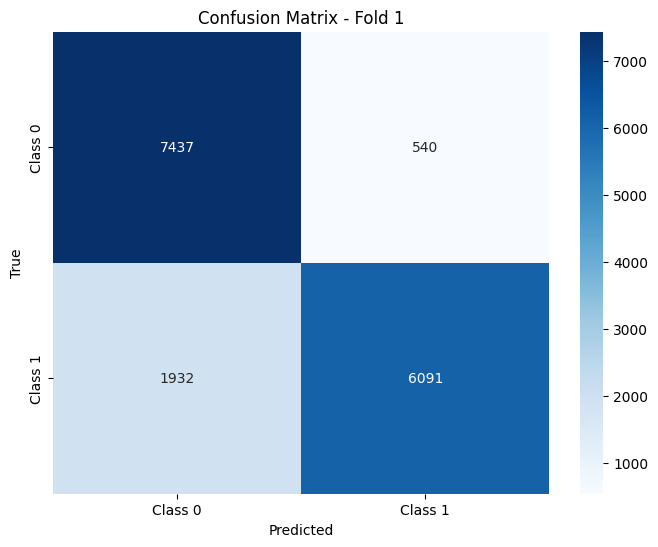

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


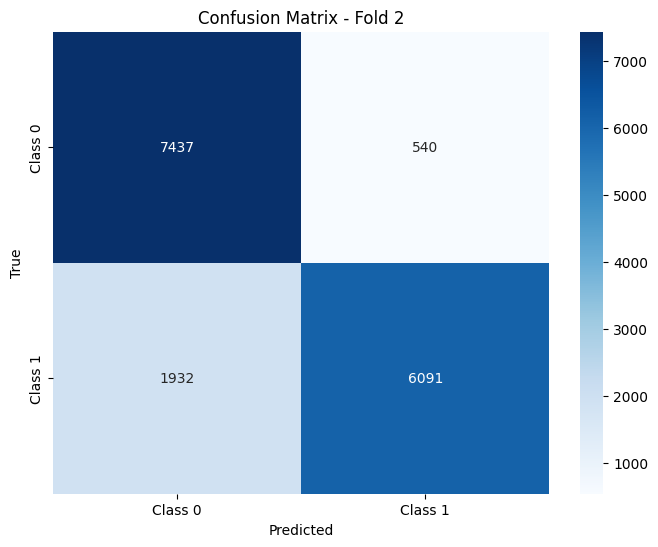

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


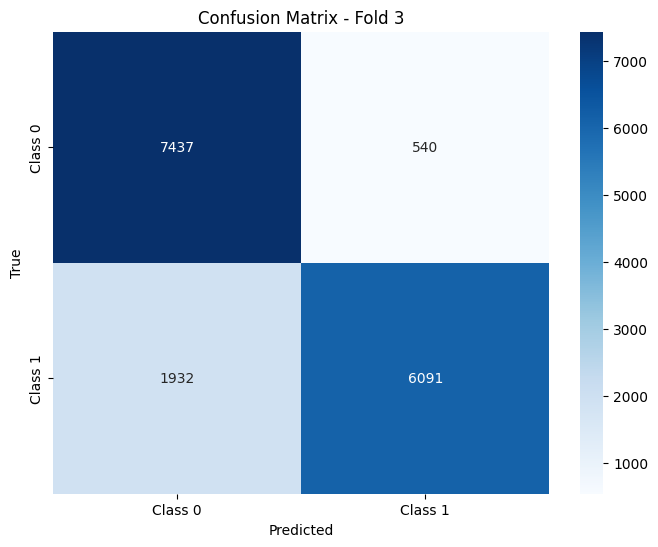

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


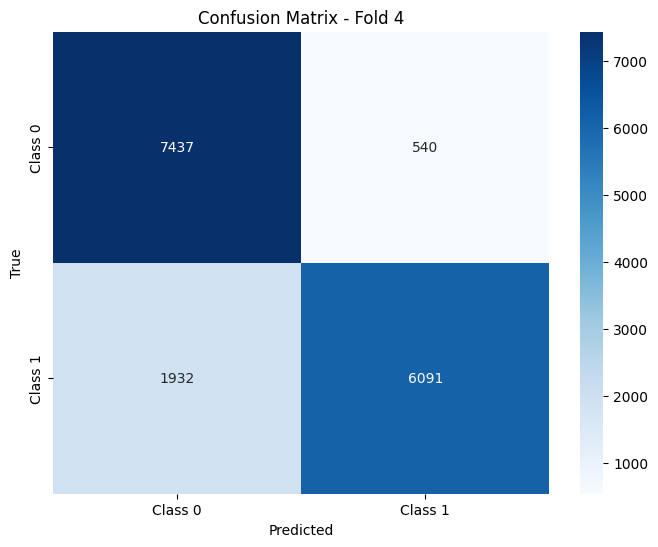

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


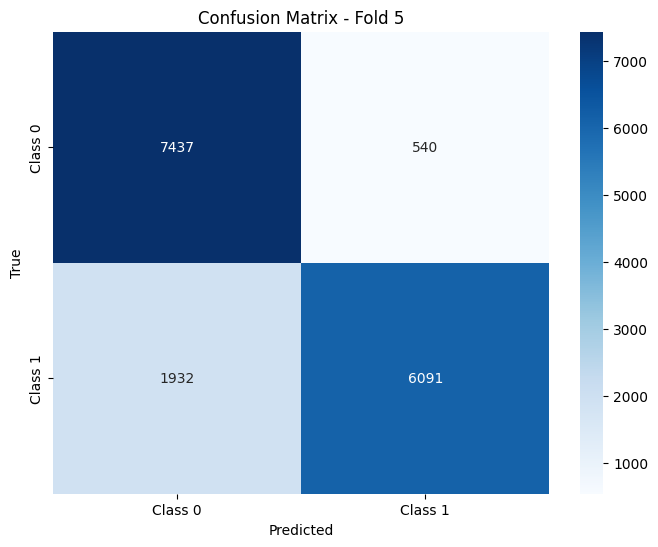

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


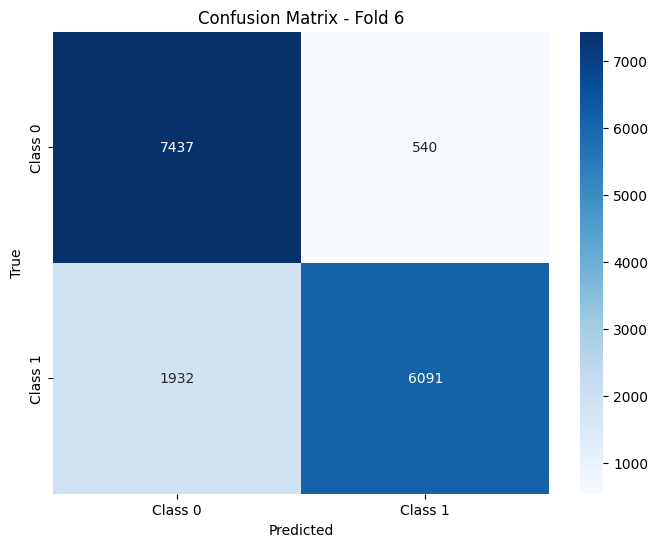

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


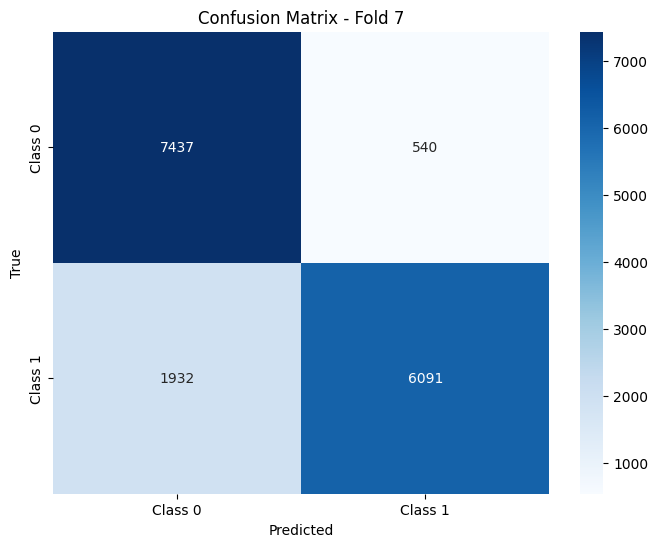

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


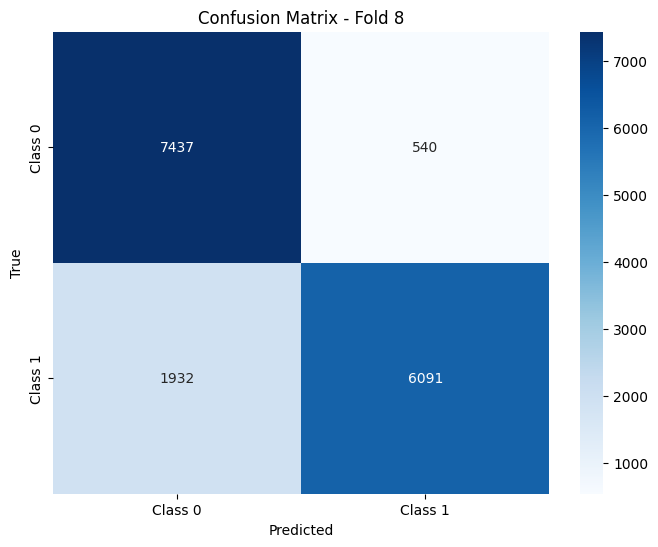

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


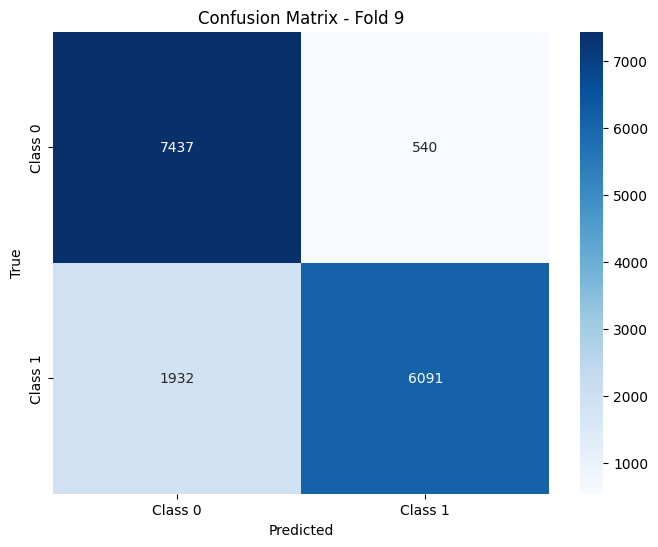

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


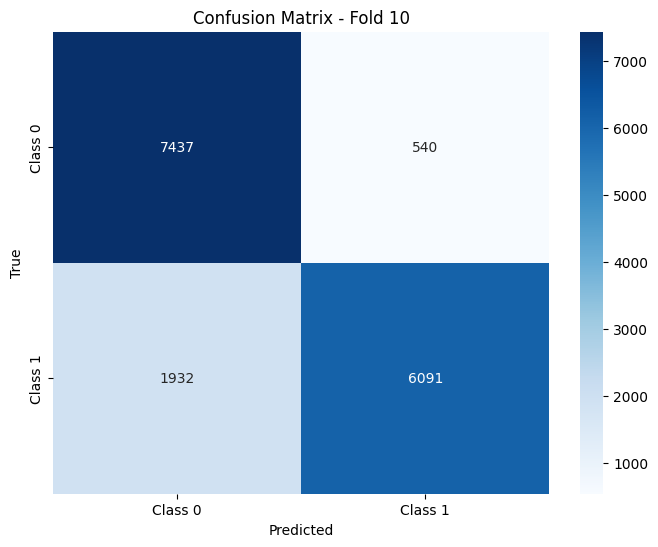

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualisasi Confusion Matrix per fold
for fold_no, history in enumerate(history_list, start=1):
    # Prediksi untuk fold tertentu
    y_pred = best_model.predict(X_val_fold) > 0.5  # Menggunakan threshold 0.5

    # Membuat confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - Fold {fold_no}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


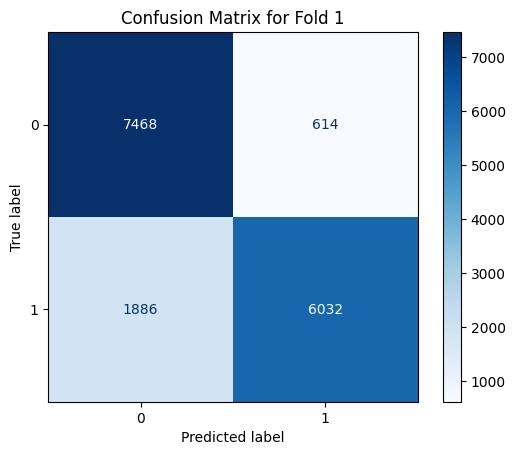

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


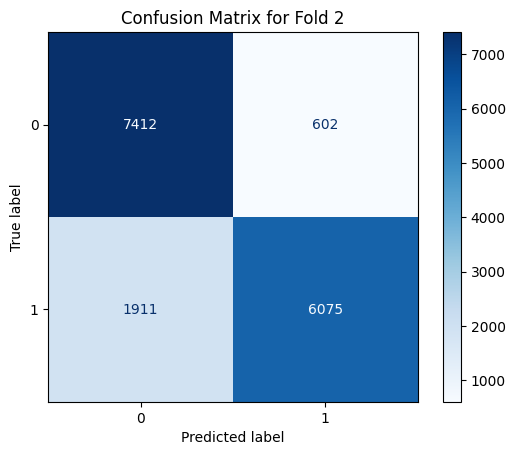

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


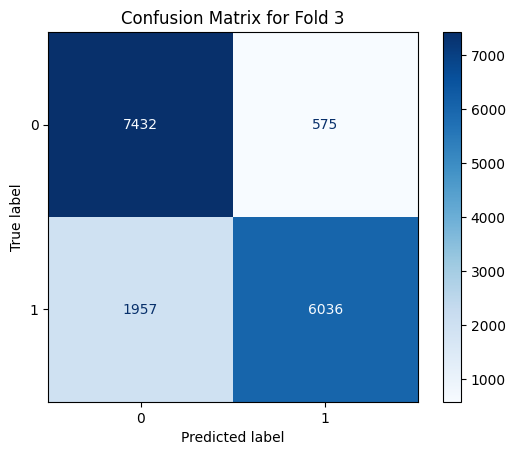

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


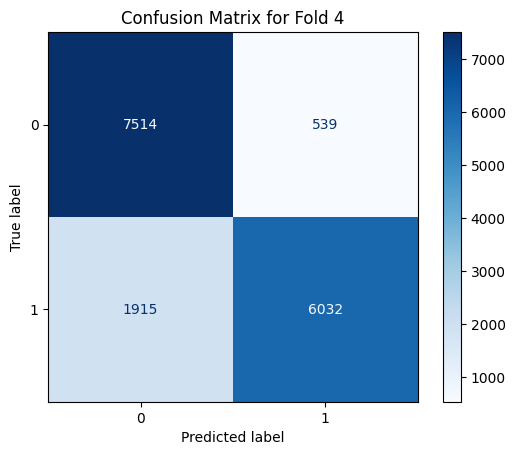

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


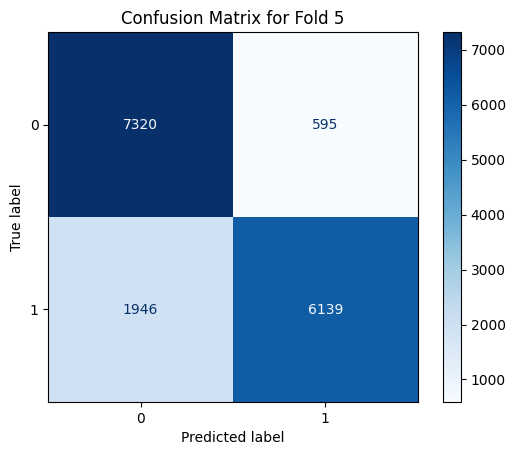

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


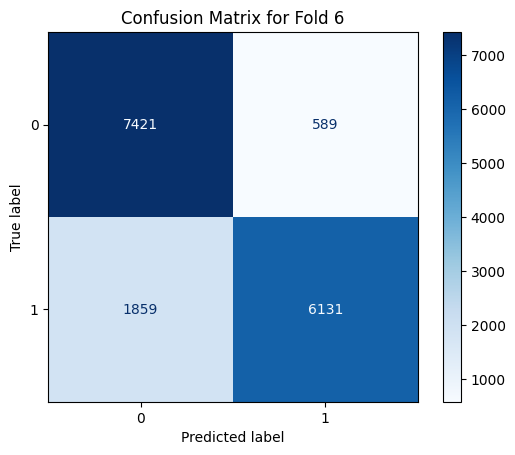

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


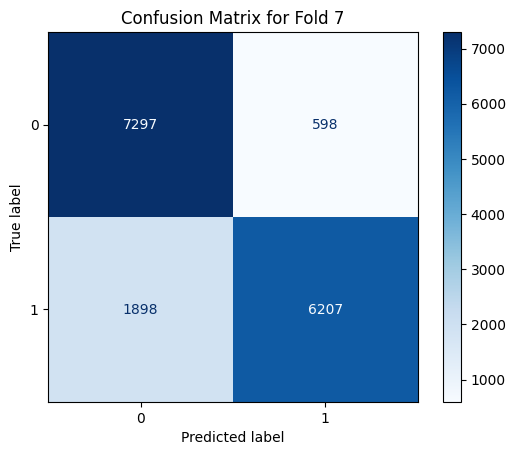

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


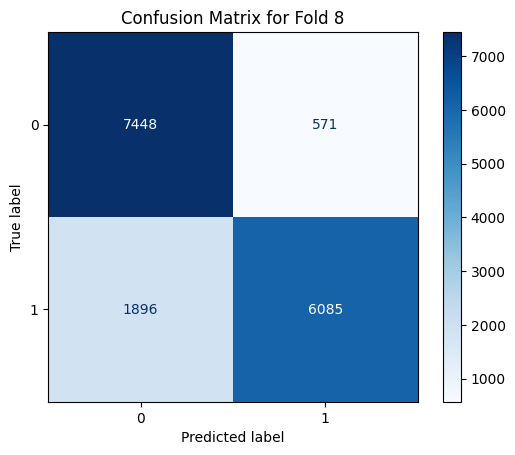

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


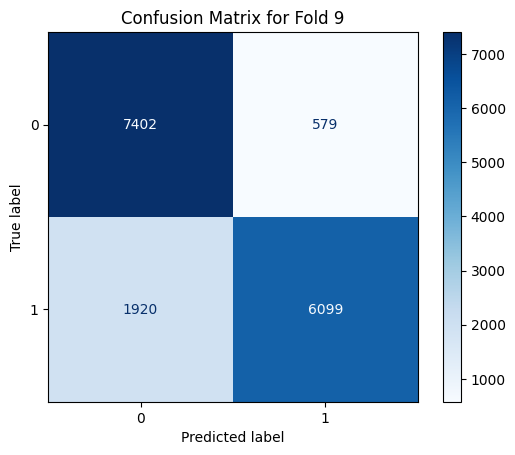

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


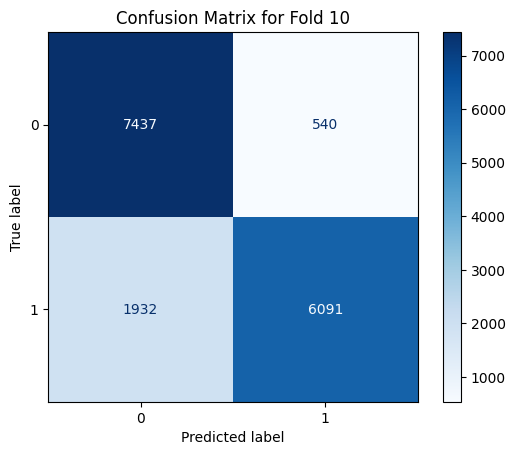

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fungsi untuk menampilkan confusion matrix
def plot_confusion_matrix(y_true, y_pred, fold_no):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

# Visualisasi confusion matrix untuk setiap fold
fold_no = 1  # Reset fold number
for train_index, val_index in kf.split(X_train):
    # Prediksi pada data validasi
    X_val_fold = X_train[val_index]
    y_val_fold = y_train[val_index]
    y_pred = best_model.predict(X_val_fold) > 0.5  # Threshold 0.5

        # Plot confusion matrix
    plot_confusion_matrix(y_val_fold, y_pred, fold_no)

    fold_no += 1

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Testing Results:
Accuracy: 84.49%
Recall: 76.15%
F1 Score: 83.05%
ROC AUC: 0.88
Loss: 13.7943


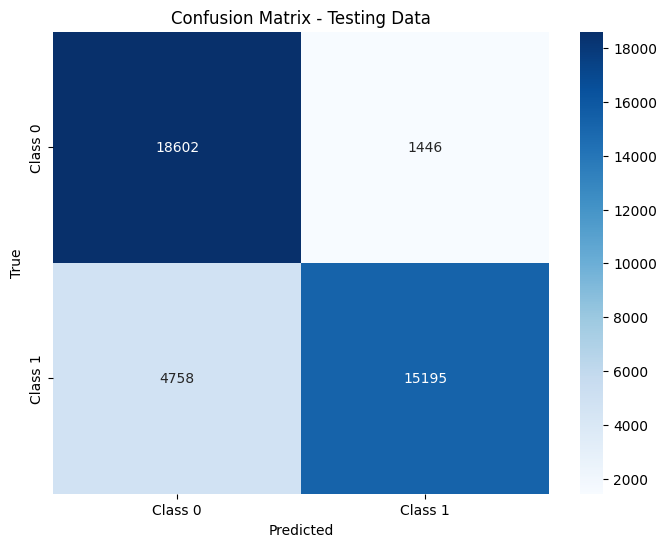

In [18]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Evaluasi pada data testing
# Prediksi probabilitas dan biner pada data testing
y_test_pred_proba = best_model.predict(X_test)  # Prediksi probabilitas
y_test_pred = (y_test_pred_proba > 0.5).astype(int)  # Prediksi biner dengan threshold 0.5

# Hitung metrik evaluasi
test_accuracy = accuracy_score(y_test, y_test_pred) * 100
test_recall = recall_score(y_test, y_test_pred) * 100
test_f1 = f1_score(y_test, y_test_pred) * 100
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

# Evaluasi loss
test_loss = best_model.evaluate(X_test, y_test, verbose=0)[0]

# Print hasil evaluasi
print(f"Testing Results:")
print(f"Accuracy: {test_accuracy:.2f}%")
print(f"Recall: {test_recall:.2f}%")
print(f"F1 Score: {test_f1:.2f}%")
print(f"ROC AUC: {test_roc_auc:.2f}")
print(f"Loss: {test_loss:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Testing Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


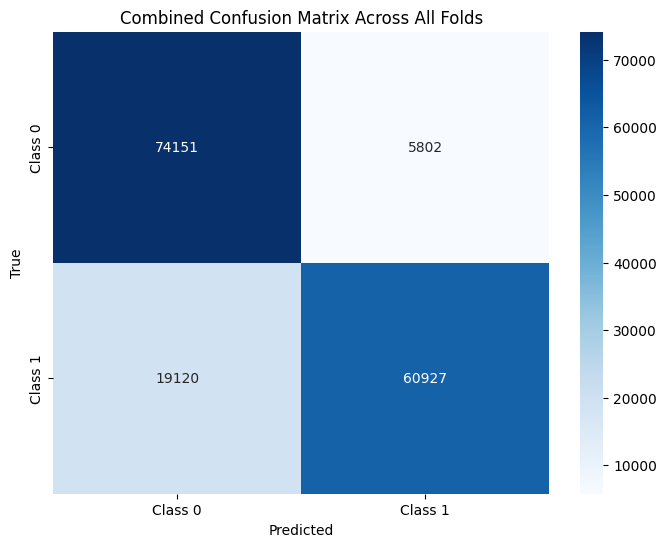

Confusion Matrix All Folds:
[[74151  5802]
 [19120 60927]]


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Inisialisasi matriks confusion gabungan
global_cm = np.zeros((2, 2), dtype=int)  # Asumsi binary classification (2x2 matrix)

for fold_no, (train_index, val_index) in enumerate(kf.split(X_train), start=1):
    # Data fold saat ini
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Prediksi pada data validasi fold ini
    y_val_pred = (best_model.predict(X_val_fold) > 0.5).astype(int)

     # Hitung matriks confusion untuk fold ini
    cm = confusion_matrix(y_val_fold, y_val_pred)

    # Tambahkan ke matriks confusion global
    global_cm += cm

# Visualisasi matriks confusion gabungan
plt.figure(figsize=(8, 6))
sns.heatmap(global_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Combined Confusion Matrix Across All Folds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print matriks confusion gabungan
print("Confusion Matrix All Folds:")
print(global_cm)